# Helpers

In [1]:
# https://github.com/spro/char-rnn.pytorch

import unidecode
import string
import random
import time
import math
import torch

# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Model

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

# Generate

In [3]:
import torch
import os
import argparse

def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

# Train

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import os

from torcheval.metrics.text import Perplexity
from tqdm import tqdm

class ArgsParser:
    filename = 'shakespeare.txt'
    model = 'lstm'
    n_epochs = 1000
    print_every = 100
    hidden_size = 100
    n_layers = 2
    learning_rate = 0.01
    chunk_len = 200
    batch_size = 100
    shuffle = True
    cuda = False
args = ArgsParser()

if args.cuda:
    print("Using CUDA")

file, file_len = read_file(args.filename)

def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    if args.cuda:
        inp = inp.cuda()
        target = target.cuda()
    return inp, target

def train(inp, target):
    hidden = decoder.init_hidden(args.batch_size)
    if args.cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(args.chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(args.batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()
    print(loss.item())
    #return loss.data[0] / args.chunk_len
    return loss.item() / args.chunk_len

def save():
    save_filename = os.path.splitext(os.path.basename(args.filename))[0] + '.pt'
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)

# Initialize models and start training

decoder = CharRNN(
    n_characters,
    args.hidden_size,
    n_characters,
    model=args.model,
    n_layers=args.n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()

if args.cuda:
    decoder.cuda()

start = time.time()
all_losses = []
all_perplexity = []
loss_avg = 0

print("Training for %d epochs..." % args.n_epochs)
for epoch in tqdm(range(1, args.n_epochs + 1)):

    loss = train(*random_training_set(args.chunk_len, args.batch_size))
    loss_avg += loss
    all_perplexity.append(2**loss)

    if epoch % args.print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / args.n_epochs * 100, loss))
        print(generate(decoder, 'Wh', 100, cuda=args.cuda), '\n')

print("Saving...")
save()

Training for 1000 epochs...


  0%|                                                                                 | 1/1000 [00:01<19:50,  1.19s/it]

919.80419921875


  0%|▏                                                                                | 2/1000 [00:02<20:44,  1.25s/it]

883.531982421875


  0%|▏                                                                                | 3/1000 [00:03<21:15,  1.28s/it]

741.7479248046875


  0%|▎                                                                                | 4/1000 [00:04<20:31,  1.24s/it]

695.254150390625


  0%|▍                                                                                | 5/1000 [00:06<21:10,  1.28s/it]

683.3759155273438


  1%|▍                                                                                | 6/1000 [00:07<22:13,  1.34s/it]

672.5421142578125


  1%|▌                                                                                | 7/1000 [00:09<22:29,  1.36s/it]

684.4241943359375


  1%|▋                                                                                | 8/1000 [00:10<22:04,  1.33s/it]

672.0883178710938


  1%|▋                                                                                | 9/1000 [00:11<21:57,  1.33s/it]

666.0542602539062


  1%|▊                                                                               | 10/1000 [00:12<21:10,  1.28s/it]

666.591796875


  1%|▉                                                                               | 11/1000 [00:14<21:24,  1.30s/it]

669.65380859375


  1%|▉                                                                               | 12/1000 [00:15<21:51,  1.33s/it]

656.0418090820312


  1%|█                                                                               | 13/1000 [00:17<22:38,  1.38s/it]

654.0386352539062


  1%|█                                                                               | 14/1000 [00:18<22:26,  1.37s/it]

649.6011962890625


  2%|█▏                                                                              | 15/1000 [00:19<22:20,  1.36s/it]

640.68896484375


  2%|█▎                                                                              | 16/1000 [00:21<21:35,  1.32s/it]

633.5703735351562


  2%|█▎                                                                              | 17/1000 [00:22<20:59,  1.28s/it]

623.0111694335938


  2%|█▍                                                                              | 18/1000 [00:23<21:28,  1.31s/it]

613.4203491210938


  2%|█▌                                                                              | 19/1000 [00:25<21:46,  1.33s/it]

607.1980590820312


  2%|█▌                                                                              | 20/1000 [00:26<22:03,  1.35s/it]

597.6492309570312


  2%|█▋                                                                              | 21/1000 [00:27<21:05,  1.29s/it]

592.9259643554688


  2%|█▊                                                                              | 22/1000 [00:28<20:48,  1.28s/it]

583.3009643554688


  2%|█▊                                                                              | 23/1000 [00:30<21:32,  1.32s/it]

574.4000244140625


  2%|█▉                                                                              | 24/1000 [00:31<20:46,  1.28s/it]

568.25537109375


  2%|██                                                                              | 25/1000 [00:32<21:41,  1.34s/it]

561.64306640625


  3%|██                                                                              | 26/1000 [00:34<21:15,  1.31s/it]

549.60205078125


  3%|██▏                                                                             | 27/1000 [00:35<21:14,  1.31s/it]

545.4200439453125


  3%|██▏                                                                             | 28/1000 [00:36<20:01,  1.24s/it]

537.7374267578125


  3%|██▎                                                                             | 29/1000 [00:37<20:27,  1.26s/it]

533.041748046875


  3%|██▍                                                                             | 30/1000 [00:39<20:04,  1.24s/it]

525.6327514648438


  3%|██▍                                                                             | 31/1000 [00:40<19:55,  1.23s/it]

519.74072265625


  3%|██▌                                                                             | 32/1000 [00:41<20:05,  1.25s/it]

515.44287109375


  3%|██▋                                                                             | 33/1000 [00:42<20:02,  1.24s/it]

503.90289306640625


  3%|██▋                                                                             | 34/1000 [00:44<20:32,  1.28s/it]

504.7852478027344


  4%|██▊                                                                             | 35/1000 [00:45<20:52,  1.30s/it]

494.7012634277344


  4%|██▉                                                                             | 36/1000 [00:46<20:29,  1.28s/it]

491.933837890625


  4%|██▉                                                                             | 37/1000 [00:47<20:18,  1.26s/it]

488.8066711425781


  4%|███                                                                             | 38/1000 [00:49<19:53,  1.24s/it]

483.4360046386719


  4%|███                                                                             | 39/1000 [00:50<20:31,  1.28s/it]

480.384033203125


  4%|███▏                                                                            | 40/1000 [00:51<21:03,  1.32s/it]

478.7152404785156


  4%|███▎                                                                            | 41/1000 [00:53<20:42,  1.30s/it]

476.6766052246094


  4%|███▎                                                                            | 42/1000 [00:54<20:32,  1.29s/it]

474.1107177734375


  4%|███▍                                                                            | 43/1000 [00:55<20:34,  1.29s/it]

469.4454040527344


  4%|███▌                                                                            | 44/1000 [00:57<21:10,  1.33s/it]

468.6794128417969


  4%|███▌                                                                            | 45/1000 [00:58<20:58,  1.32s/it]

462.4759216308594


  5%|███▋                                                                            | 46/1000 [00:59<20:44,  1.30s/it]

468.80401611328125


  5%|███▊                                                                            | 47/1000 [01:01<20:55,  1.32s/it]

460.1429443359375


  5%|███▊                                                                            | 48/1000 [01:02<20:38,  1.30s/it]

459.0783996582031


  5%|███▉                                                                            | 49/1000 [01:03<20:55,  1.32s/it]

452.9466247558594


  5%|████                                                                            | 50/1000 [01:05<21:07,  1.33s/it]

447.62158203125


  5%|████                                                                            | 51/1000 [01:06<20:51,  1.32s/it]

454.0208740234375


  5%|████▏                                                                           | 52/1000 [01:07<20:59,  1.33s/it]

448.5968017578125


  5%|████▏                                                                           | 53/1000 [01:08<20:55,  1.33s/it]

449.0846862792969


  5%|████▎                                                                           | 54/1000 [01:10<21:07,  1.34s/it]

444.5485534667969


  6%|████▍                                                                           | 55/1000 [01:11<20:57,  1.33s/it]

443.6162109375


  6%|████▍                                                                           | 56/1000 [01:13<21:01,  1.34s/it]

441.370361328125


  6%|████▌                                                                           | 57/1000 [01:14<21:08,  1.35s/it]

439.0555114746094


  6%|████▋                                                                           | 58/1000 [01:15<20:32,  1.31s/it]

441.7959289550781


  6%|████▋                                                                           | 59/1000 [01:16<20:00,  1.28s/it]

437.7125244140625


  6%|████▊                                                                           | 60/1000 [01:18<20:39,  1.32s/it]

435.17645263671875


  6%|████▉                                                                           | 61/1000 [01:19<21:06,  1.35s/it]

430.43389892578125


  6%|████▉                                                                           | 62/1000 [01:20<20:45,  1.33s/it]

430.118896484375


  6%|█████                                                                           | 63/1000 [01:22<20:06,  1.29s/it]

431.51800537109375


  6%|█████                                                                           | 64/1000 [01:23<20:47,  1.33s/it]

429.9356689453125


  6%|█████▏                                                                          | 65/1000 [01:24<19:55,  1.28s/it]

429.6625061035156


  7%|█████▎                                                                          | 66/1000 [01:25<19:31,  1.25s/it]

429.8314514160156


  7%|█████▎                                                                          | 67/1000 [01:27<19:20,  1.24s/it]

428.30072021484375


  7%|█████▍                                                                          | 68/1000 [01:28<18:43,  1.21s/it]

427.1738586425781


  7%|█████▌                                                                          | 69/1000 [01:29<19:32,  1.26s/it]

421.2958068847656


  7%|█████▌                                                                          | 70/1000 [01:30<19:24,  1.25s/it]

420.7757568359375


  7%|█████▋                                                                          | 71/1000 [01:32<19:46,  1.28s/it]

422.7887878417969


  7%|█████▊                                                                          | 72/1000 [01:33<19:49,  1.28s/it]

423.3981018066406


  7%|█████▊                                                                          | 73/1000 [01:34<18:46,  1.22s/it]

421.10589599609375


  7%|█████▉                                                                          | 74/1000 [01:35<18:31,  1.20s/it]

414.9294738769531


  8%|██████                                                                          | 75/1000 [01:37<19:24,  1.26s/it]

412.7742614746094


  8%|██████                                                                          | 76/1000 [01:38<19:29,  1.27s/it]

410.0588073730469


  8%|██████▏                                                                         | 77/1000 [01:39<19:21,  1.26s/it]

414.54693603515625


  8%|██████▏                                                                         | 78/1000 [01:40<19:32,  1.27s/it]

413.4617614746094


  8%|██████▎                                                                         | 79/1000 [01:42<20:45,  1.35s/it]

413.2123107910156


  8%|██████▍                                                                         | 80/1000 [01:43<20:46,  1.35s/it]

409.51922607421875


  8%|██████▍                                                                         | 81/1000 [01:45<20:00,  1.31s/it]

406.8033752441406


  8%|██████▌                                                                         | 82/1000 [01:46<19:49,  1.30s/it]

407.76165771484375


  8%|██████▋                                                                         | 83/1000 [01:47<19:45,  1.29s/it]

402.2460632324219


  8%|██████▋                                                                         | 84/1000 [01:48<18:50,  1.23s/it]

400.0768737792969


  8%|██████▊                                                                         | 85/1000 [01:50<19:42,  1.29s/it]

402.1629638671875


  9%|██████▉                                                                         | 86/1000 [01:51<19:18,  1.27s/it]

401.04132080078125


  9%|██████▉                                                                         | 87/1000 [01:52<19:30,  1.28s/it]

397.4854736328125


  9%|███████                                                                         | 88/1000 [01:54<20:29,  1.35s/it]

398.7416076660156


  9%|███████                                                                         | 89/1000 [01:55<20:32,  1.35s/it]

398.4801025390625


  9%|███████▏                                                                        | 90/1000 [01:57<21:14,  1.40s/it]

395.6918029785156


  9%|███████▎                                                                        | 91/1000 [01:58<20:31,  1.35s/it]

391.17669677734375


  9%|███████▎                                                                        | 92/1000 [01:59<20:12,  1.34s/it]

397.0779724121094


  9%|███████▍                                                                        | 93/1000 [02:00<19:34,  1.29s/it]

391.0616149902344


  9%|███████▌                                                                        | 94/1000 [02:02<19:55,  1.32s/it]

390.1823425292969


 10%|███████▌                                                                        | 95/1000 [02:03<19:48,  1.31s/it]

390.9148254394531


 10%|███████▋                                                                        | 96/1000 [02:04<20:03,  1.33s/it]

390.6474914550781


 10%|███████▊                                                                        | 97/1000 [02:06<20:40,  1.37s/it]

388.8979797363281


 10%|███████▊                                                                        | 98/1000 [02:07<19:53,  1.32s/it]

391.0304260253906


 10%|███████▉                                                                        | 99/1000 [02:08<19:36,  1.31s/it]

385.74639892578125


 10%|███████▉                                                                       | 100/1000 [02:10<19:40,  1.31s/it]

388.17999267578125
 10s (100 10%) 1.9409]
Wher'd iven'sed
Mescove preadow this sish; morish:
Which dished
bed, in of frome?

ALY:
I may nost sil 



 10%|███████▉                                                                       | 101/1000 [02:11<20:08,  1.34s/it]

383.8905944824219


 10%|████████                                                                       | 102/1000 [02:12<20:27,  1.37s/it]

383.7666931152344


 10%|████████▏                                                                      | 103/1000 [02:14<20:10,  1.35s/it]

383.7795715332031


 10%|████████▏                                                                      | 104/1000 [02:15<19:50,  1.33s/it]

383.8962097167969


 10%|████████▎                                                                      | 105/1000 [02:16<19:01,  1.28s/it]

388.57684326171875


 11%|████████▎                                                                      | 106/1000 [02:17<18:51,  1.27s/it]

389.705078125


 11%|████████▍                                                                      | 107/1000 [02:19<18:38,  1.25s/it]

382.2723388671875


 11%|████████▌                                                                      | 108/1000 [02:20<18:35,  1.25s/it]

378.2440185546875


 11%|████████▌                                                                      | 109/1000 [02:21<18:06,  1.22s/it]

379.64971923828125


 11%|████████▋                                                                      | 110/1000 [02:22<18:19,  1.24s/it]

375.1818542480469


 11%|████████▊                                                                      | 111/1000 [02:24<18:30,  1.25s/it]

376.5438537597656


 11%|████████▊                                                                      | 112/1000 [02:25<19:07,  1.29s/it]

373.6680908203125


 11%|████████▉                                                                      | 113/1000 [02:26<18:26,  1.25s/it]

377.32513427734375


 11%|█████████                                                                      | 114/1000 [02:27<17:51,  1.21s/it]

370.8762512207031


 12%|█████████                                                                      | 115/1000 [02:29<18:40,  1.27s/it]

370.625732421875


 12%|█████████▏                                                                     | 116/1000 [02:30<19:06,  1.30s/it]

377.35247802734375


 12%|█████████▏                                                                     | 117/1000 [02:31<19:05,  1.30s/it]

375.06988525390625


 12%|█████████▎                                                                     | 118/1000 [02:32<18:34,  1.26s/it]

369.042236328125


 12%|█████████▍                                                                     | 119/1000 [02:34<18:54,  1.29s/it]

375.0837097167969


 12%|█████████▍                                                                     | 120/1000 [02:35<18:53,  1.29s/it]

365.9476013183594


 12%|█████████▌                                                                     | 121/1000 [02:36<18:34,  1.27s/it]

372.8894348144531


 12%|█████████▋                                                                     | 122/1000 [02:38<18:53,  1.29s/it]

368.480712890625


 12%|█████████▋                                                                     | 123/1000 [02:39<18:51,  1.29s/it]

371.5443420410156


 12%|█████████▊                                                                     | 124/1000 [02:40<18:38,  1.28s/it]

369.0030517578125


 12%|█████████▉                                                                     | 125/1000 [02:41<17:34,  1.21s/it]

363.5797424316406


 13%|█████████▉                                                                     | 126/1000 [02:42<17:17,  1.19s/it]

365.88153076171875


 13%|██████████                                                                     | 127/1000 [02:44<17:47,  1.22s/it]

365.98236083984375


 13%|██████████                                                                     | 128/1000 [02:45<17:41,  1.22s/it]

366.3847961425781


 13%|██████████▏                                                                    | 129/1000 [02:46<17:15,  1.19s/it]

363.5213317871094


 13%|██████████▎                                                                    | 130/1000 [02:47<18:03,  1.25s/it]

366.24005126953125


 13%|██████████▎                                                                    | 131/1000 [02:49<18:03,  1.25s/it]

370.320068359375


 13%|██████████▍                                                                    | 132/1000 [02:50<17:54,  1.24s/it]

366.39813232421875


 13%|██████████▌                                                                    | 133/1000 [02:51<18:12,  1.26s/it]

364.7852783203125


 13%|██████████▌                                                                    | 134/1000 [02:53<18:42,  1.30s/it]

356.3361511230469


 14%|██████████▋                                                                    | 135/1000 [02:54<18:19,  1.27s/it]

364.2098693847656


 14%|██████████▋                                                                    | 136/1000 [02:55<18:54,  1.31s/it]

357.5656433105469


 14%|██████████▊                                                                    | 137/1000 [02:56<18:45,  1.30s/it]

362.7017822265625


 14%|██████████▉                                                                    | 138/1000 [02:58<18:29,  1.29s/it]

362.71868896484375


 14%|██████████▉                                                                    | 139/1000 [02:59<18:14,  1.27s/it]

356.75018310546875


 14%|███████████                                                                    | 140/1000 [03:00<18:14,  1.27s/it]

364.5688171386719


 14%|███████████▏                                                                   | 141/1000 [03:02<19:04,  1.33s/it]

358.4038391113281


 14%|███████████▏                                                                   | 142/1000 [03:03<18:46,  1.31s/it]

359.49127197265625


 14%|███████████▎                                                                   | 143/1000 [03:04<18:13,  1.28s/it]

356.33941650390625


 14%|███████████▍                                                                   | 144/1000 [03:05<18:24,  1.29s/it]

360.3129577636719


 14%|███████████▍                                                                   | 145/1000 [03:07<17:40,  1.24s/it]

358.53668212890625


 15%|███████████▌                                                                   | 146/1000 [03:08<17:42,  1.24s/it]

358.1212158203125


 15%|███████████▌                                                                   | 147/1000 [03:09<18:26,  1.30s/it]

353.3341064453125


 15%|███████████▋                                                                   | 148/1000 [03:11<18:51,  1.33s/it]

361.0939636230469


 15%|███████████▊                                                                   | 149/1000 [03:12<18:05,  1.28s/it]

356.8905944824219


 15%|███████████▊                                                                   | 150/1000 [03:13<18:16,  1.29s/it]

357.88861083984375


 15%|███████████▉                                                                   | 151/1000 [03:14<17:59,  1.27s/it]

354.0858154296875


 15%|████████████                                                                   | 152/1000 [03:16<17:52,  1.27s/it]

352.9393310546875


 15%|████████████                                                                   | 153/1000 [03:17<17:23,  1.23s/it]

353.2008361816406


 15%|████████████▏                                                                  | 154/1000 [03:18<18:14,  1.29s/it]

353.5582275390625


 16%|████████████▏                                                                  | 155/1000 [03:19<17:27,  1.24s/it]

354.6705017089844


 16%|████████████▎                                                                  | 156/1000 [03:21<17:42,  1.26s/it]

351.85699462890625


 16%|████████████▍                                                                  | 157/1000 [03:22<17:39,  1.26s/it]

350.7779846191406


 16%|████████████▍                                                                  | 158/1000 [03:23<17:58,  1.28s/it]

348.83526611328125


 16%|████████████▌                                                                  | 159/1000 [03:24<17:41,  1.26s/it]

350.5043640136719


 16%|████████████▋                                                                  | 160/1000 [03:26<18:01,  1.29s/it]

347.9518737792969


 16%|████████████▋                                                                  | 161/1000 [03:27<18:15,  1.31s/it]

354.3052062988281


 16%|████████████▊                                                                  | 162/1000 [03:28<17:31,  1.26s/it]

349.15545654296875


 16%|████████████▉                                                                  | 163/1000 [03:29<17:18,  1.24s/it]

354.0050048828125


 16%|████████████▉                                                                  | 164/1000 [03:31<17:15,  1.24s/it]

348.9844665527344


 16%|█████████████                                                                  | 165/1000 [03:32<16:52,  1.21s/it]

349.2770690917969


 17%|█████████████                                                                  | 166/1000 [03:33<16:47,  1.21s/it]

347.65264892578125


 17%|█████████████▏                                                                 | 167/1000 [03:34<16:08,  1.16s/it]

342.4973449707031


 17%|█████████████▎                                                                 | 168/1000 [03:35<16:14,  1.17s/it]

349.1910400390625


 17%|█████████████▎                                                                 | 169/1000 [03:37<16:18,  1.18s/it]

348.6676940917969


 17%|█████████████▍                                                                 | 170/1000 [03:38<16:44,  1.21s/it]

351.15997314453125


 17%|█████████████▌                                                                 | 171/1000 [03:39<16:34,  1.20s/it]

338.5216979980469


 17%|█████████████▌                                                                 | 172/1000 [03:40<16:36,  1.20s/it]

343.0700378417969


 17%|█████████████▋                                                                 | 173/1000 [03:41<16:51,  1.22s/it]

348.6667175292969


 17%|█████████████▋                                                                 | 174/1000 [03:43<16:26,  1.19s/it]

342.9759521484375


 18%|█████████████▊                                                                 | 175/1000 [03:44<16:31,  1.20s/it]

344.8541259765625


 18%|█████████████▉                                                                 | 176/1000 [03:45<16:43,  1.22s/it]

342.8606262207031


 18%|█████████████▉                                                                 | 177/1000 [03:47<17:42,  1.29s/it]

343.05047607421875


 18%|██████████████                                                                 | 178/1000 [03:48<18:05,  1.32s/it]

344.7955322265625


 18%|██████████████▏                                                                | 179/1000 [03:49<17:25,  1.27s/it]

340.6855773925781


 18%|██████████████▏                                                                | 180/1000 [03:50<16:43,  1.22s/it]

339.5118408203125


 18%|██████████████▎                                                                | 181/1000 [03:52<17:13,  1.26s/it]

341.21649169921875


 18%|██████████████▍                                                                | 182/1000 [03:53<18:14,  1.34s/it]

343.8055725097656


 18%|██████████████▍                                                                | 183/1000 [03:54<18:30,  1.36s/it]

339.99603271484375


 18%|██████████████▌                                                                | 184/1000 [03:56<18:22,  1.35s/it]

340.810546875


 18%|██████████████▌                                                                | 185/1000 [03:57<18:08,  1.34s/it]

341.25030517578125


 19%|██████████████▋                                                                | 186/1000 [03:58<17:30,  1.29s/it]

340.7466125488281


 19%|██████████████▊                                                                | 187/1000 [04:00<17:29,  1.29s/it]

342.84405517578125


 19%|██████████████▊                                                                | 188/1000 [04:01<16:41,  1.23s/it]

344.1357727050781


 19%|██████████████▉                                                                | 189/1000 [04:02<16:27,  1.22s/it]

336.27862548828125


 19%|███████████████                                                                | 190/1000 [04:03<17:03,  1.26s/it]

338.7626647949219


 19%|███████████████                                                                | 191/1000 [04:04<16:35,  1.23s/it]

339.5849914550781


 19%|███████████████▏                                                               | 192/1000 [04:06<16:53,  1.25s/it]

337.0535583496094


 19%|███████████████▏                                                               | 193/1000 [04:07<17:32,  1.30s/it]

342.74212646484375


 19%|███████████████▎                                                               | 194/1000 [04:08<17:33,  1.31s/it]

341.4915771484375


 20%|███████████████▍                                                               | 195/1000 [04:10<17:42,  1.32s/it]

340.87847900390625


 20%|███████████████▍                                                               | 196/1000 [04:11<17:17,  1.29s/it]

339.9354248046875


 20%|███████████████▌                                                               | 197/1000 [04:12<16:50,  1.26s/it]

337.45306396484375


 20%|███████████████▋                                                               | 198/1000 [04:13<16:50,  1.26s/it]

337.6399230957031


 20%|███████████████▋                                                               | 199/1000 [04:15<16:12,  1.21s/it]

342.40283203125


 20%|███████████████▊                                                               | 200/1000 [04:16<16:47,  1.26s/it]

336.35491943359375
 16s (200 20%) 1.6818]
Whas the falked.

PETRUCHIO:
Why, your parth; pentle the lost retturses, this word of the sextion.

ME 



 20%|███████████████▉                                                               | 201/1000 [04:17<16:21,  1.23s/it]

337.4150390625


 20%|███████████████▉                                                               | 202/1000 [04:18<16:22,  1.23s/it]

336.75518798828125


 20%|████████████████                                                               | 203/1000 [04:20<16:31,  1.24s/it]

336.0263977050781


 20%|████████████████                                                               | 204/1000 [04:21<16:51,  1.27s/it]

335.33685302734375


 20%|████████████████▏                                                              | 205/1000 [04:22<16:56,  1.28s/it]

330.2217712402344


 21%|████████████████▎                                                              | 206/1000 [04:23<16:58,  1.28s/it]

337.9012451171875


 21%|████████████████▎                                                              | 207/1000 [04:25<16:22,  1.24s/it]

332.6369934082031


 21%|████████████████▍                                                              | 208/1000 [04:26<15:55,  1.21s/it]

337.85400390625


 21%|████████████████▌                                                              | 209/1000 [04:27<15:59,  1.21s/it]

337.3819580078125


 21%|████████████████▌                                                              | 210/1000 [04:28<15:43,  1.19s/it]

342.0438232421875


 21%|████████████████▋                                                              | 211/1000 [04:30<16:24,  1.25s/it]

331.2882080078125


 21%|████████████████▋                                                              | 212/1000 [04:31<16:23,  1.25s/it]

331.9399719238281


 21%|████████████████▊                                                              | 213/1000 [04:32<16:42,  1.27s/it]

337.4041442871094


 21%|████████████████▉                                                              | 214/1000 [04:33<16:21,  1.25s/it]

336.7896423339844


 22%|████████████████▉                                                              | 215/1000 [04:35<16:46,  1.28s/it]

333.78594970703125


 22%|█████████████████                                                              | 216/1000 [04:36<16:39,  1.28s/it]

333.9667053222656


 22%|█████████████████▏                                                             | 217/1000 [04:37<16:32,  1.27s/it]

327.2783203125


 22%|█████████████████▏                                                             | 218/1000 [04:38<16:17,  1.25s/it]

336.67254638671875


 22%|█████████████████▎                                                             | 219/1000 [04:40<15:53,  1.22s/it]

329.4142150878906


 22%|█████████████████▍                                                             | 220/1000 [04:41<15:45,  1.21s/it]

333.9156494140625


 22%|█████████████████▍                                                             | 221/1000 [04:42<15:55,  1.23s/it]

335.4185485839844


 22%|█████████████████▌                                                             | 222/1000 [04:43<16:13,  1.25s/it]

334.7206726074219


 22%|█████████████████▌                                                             | 223/1000 [04:44<16:03,  1.24s/it]

333.1429748535156


 22%|█████████████████▋                                                             | 224/1000 [04:46<16:46,  1.30s/it]

331.0519714355469


 22%|█████████████████▊                                                             | 225/1000 [04:47<16:08,  1.25s/it]

328.6361389160156


 23%|█████████████████▊                                                             | 226/1000 [04:48<16:11,  1.25s/it]

332.3395690917969


 23%|█████████████████▉                                                             | 227/1000 [04:50<16:27,  1.28s/it]

334.43817138671875


 23%|██████████████████                                                             | 228/1000 [04:51<16:27,  1.28s/it]

331.4523010253906


 23%|██████████████████                                                             | 229/1000 [04:52<15:37,  1.22s/it]

334.0030212402344


 23%|██████████████████▏                                                            | 230/1000 [04:53<15:30,  1.21s/it]

324.6415100097656


 23%|██████████████████▏                                                            | 231/1000 [04:54<15:33,  1.21s/it]

331.897705078125


 23%|██████████████████▎                                                            | 232/1000 [04:56<16:28,  1.29s/it]

335.40814208984375


 23%|██████████████████▍                                                            | 233/1000 [04:57<17:19,  1.36s/it]

337.22967529296875


 23%|██████████████████▍                                                            | 234/1000 [04:59<16:32,  1.30s/it]

326.83355712890625


 24%|██████████████████▌                                                            | 235/1000 [05:00<16:33,  1.30s/it]

323.5833435058594


 24%|██████████████████▋                                                            | 236/1000 [05:01<16:14,  1.28s/it]

324.8140869140625


 24%|██████████████████▋                                                            | 237/1000 [05:03<19:06,  1.50s/it]

327.3981628417969


 24%|██████████████████▊                                                            | 238/1000 [05:05<18:57,  1.49s/it]

326.18060302734375


 24%|██████████████████▉                                                            | 239/1000 [05:06<17:20,  1.37s/it]

324.2496643066406


 24%|██████████████████▉                                                            | 240/1000 [05:07<16:14,  1.28s/it]

324.037109375


 24%|███████████████████                                                            | 241/1000 [05:08<17:13,  1.36s/it]

327.85137939453125


 24%|███████████████████                                                            | 242/1000 [05:10<17:09,  1.36s/it]

326.5176696777344


 24%|███████████████████▏                                                           | 243/1000 [05:11<17:20,  1.38s/it]

327.0331726074219


 24%|███████████████████▎                                                           | 244/1000 [05:12<17:16,  1.37s/it]

329.5072021484375


 24%|███████████████████▎                                                           | 245/1000 [05:14<16:55,  1.35s/it]

325.3346862792969


 25%|███████████████████▍                                                           | 246/1000 [05:15<16:38,  1.32s/it]

323.85394287109375


 25%|███████████████████▌                                                           | 247/1000 [05:16<16:23,  1.31s/it]

323.26519775390625


 25%|███████████████████▌                                                           | 248/1000 [05:17<15:50,  1.26s/it]

325.19586181640625


 25%|███████████████████▋                                                           | 249/1000 [05:19<15:19,  1.22s/it]

327.55377197265625


 25%|███████████████████▊                                                           | 250/1000 [05:20<15:35,  1.25s/it]

327.0504455566406


 25%|███████████████████▊                                                           | 251/1000 [05:21<15:03,  1.21s/it]

325.24249267578125


 25%|███████████████████▉                                                           | 252/1000 [05:22<15:03,  1.21s/it]

323.1235656738281


 25%|███████████████████▉                                                           | 253/1000 [05:23<15:06,  1.21s/it]

325.0330505371094


 25%|████████████████████                                                           | 254/1000 [05:25<15:23,  1.24s/it]

323.6595764160156


 26%|████████████████████▏                                                          | 255/1000 [05:26<15:43,  1.27s/it]

328.2346496582031


 26%|████████████████████▏                                                          | 256/1000 [05:27<15:13,  1.23s/it]

326.0234680175781


 26%|████████████████████▎                                                          | 257/1000 [05:28<14:53,  1.20s/it]

324.97027587890625


 26%|████████████████████▍                                                          | 258/1000 [05:30<15:00,  1.21s/it]

326.5982971191406


 26%|████████████████████▍                                                          | 259/1000 [05:31<14:57,  1.21s/it]

319.9349060058594


 26%|████████████████████▌                                                          | 260/1000 [05:32<15:50,  1.28s/it]

318.6796569824219


 26%|████████████████████▌                                                          | 261/1000 [05:33<15:27,  1.25s/it]

326.39154052734375


 26%|████████████████████▋                                                          | 262/1000 [05:35<16:09,  1.31s/it]

323.1200866699219


 26%|████████████████████▊                                                          | 263/1000 [05:36<16:56,  1.38s/it]

320.2469482421875


 26%|████████████████████▊                                                          | 264/1000 [05:38<16:08,  1.32s/it]

322.8078308105469


 26%|████████████████████▉                                                          | 265/1000 [05:39<16:24,  1.34s/it]

318.3730163574219


 27%|█████████████████████                                                          | 266/1000 [05:40<16:28,  1.35s/it]

323.0271301269531


 27%|█████████████████████                                                          | 267/1000 [05:42<16:19,  1.34s/it]

319.7859802246094


 27%|█████████████████████▏                                                         | 268/1000 [05:43<16:02,  1.31s/it]

322.74371337890625


 27%|█████████████████████▎                                                         | 269/1000 [05:44<16:45,  1.38s/it]

328.6324462890625


 27%|█████████████████████▎                                                         | 270/1000 [05:46<16:35,  1.36s/it]

322.56390380859375


 27%|█████████████████████▍                                                         | 271/1000 [05:47<16:05,  1.32s/it]

321.1353759765625


 27%|█████████████████████▍                                                         | 272/1000 [05:48<16:21,  1.35s/it]

322.65216064453125


 27%|█████████████████████▌                                                         | 273/1000 [05:49<15:33,  1.28s/it]

318.9575500488281


 27%|█████████████████████▋                                                         | 274/1000 [05:51<15:08,  1.25s/it]

326.6412658691406


 28%|█████████████████████▋                                                         | 275/1000 [05:52<14:55,  1.24s/it]

316.9814453125


 28%|█████████████████████▊                                                         | 276/1000 [05:53<14:29,  1.20s/it]

318.34747314453125


 28%|█████████████████████▉                                                         | 277/1000 [05:54<14:33,  1.21s/it]

320.8963623046875


 28%|█████████████████████▉                                                         | 278/1000 [05:57<18:43,  1.56s/it]

318.7194519042969


 28%|██████████████████████                                                         | 279/1000 [05:58<17:46,  1.48s/it]

317.5950012207031


 28%|██████████████████████                                                         | 280/1000 [05:59<18:00,  1.50s/it]

318.9813232421875


 28%|██████████████████████▏                                                        | 281/1000 [06:01<17:20,  1.45s/it]

325.7522888183594


 28%|██████████████████████▎                                                        | 282/1000 [06:02<17:15,  1.44s/it]

319.3779296875


 28%|██████████████████████▎                                                        | 283/1000 [06:03<16:10,  1.35s/it]

321.7437744140625


 28%|██████████████████████▍                                                        | 284/1000 [06:04<14:54,  1.25s/it]

322.0610046386719


 28%|██████████████████████▌                                                        | 285/1000 [06:06<15:02,  1.26s/it]

317.07916259765625


 29%|██████████████████████▌                                                        | 286/1000 [06:07<14:59,  1.26s/it]

324.45758056640625


 29%|██████████████████████▋                                                        | 287/1000 [06:08<15:20,  1.29s/it]

321.00885009765625


 29%|██████████████████████▊                                                        | 288/1000 [06:10<15:20,  1.29s/it]

322.3187255859375


 29%|██████████████████████▊                                                        | 289/1000 [06:11<15:20,  1.29s/it]

316.5180358886719


 29%|██████████████████████▉                                                        | 290/1000 [06:12<15:36,  1.32s/it]

319.43853759765625


 29%|██████████████████████▉                                                        | 291/1000 [06:14<15:46,  1.33s/it]

320.6988220214844


 29%|███████████████████████                                                        | 292/1000 [06:15<15:58,  1.35s/it]

315.89691162109375


 29%|███████████████████████▏                                                       | 293/1000 [06:17<17:18,  1.47s/it]

316.1971740722656


 29%|███████████████████████▏                                                       | 294/1000 [06:18<16:45,  1.42s/it]

316.51641845703125


 30%|███████████████████████▎                                                       | 295/1000 [06:19<15:51,  1.35s/it]

320.23828125


 30%|███████████████████████▍                                                       | 296/1000 [06:20<14:59,  1.28s/it]

313.72967529296875


 30%|███████████████████████▍                                                       | 297/1000 [06:21<14:30,  1.24s/it]

323.8616943359375


 30%|███████████████████████▌                                                       | 298/1000 [06:23<15:03,  1.29s/it]

317.00164794921875


 30%|███████████████████████▌                                                       | 299/1000 [06:24<15:15,  1.31s/it]

315.9844970703125


 30%|███████████████████████▋                                                       | 300/1000 [06:26<15:56,  1.37s/it]

322.40966796875
 26s (300 30%) 1.6120]
What shis wamles to men'd blows of volband;
Our wast all it have silt both, for the queen honour,
Dnes 



 30%|███████████████████████▊                                                       | 301/1000 [06:27<16:59,  1.46s/it]

315.56622314453125


 30%|███████████████████████▊                                                       | 302/1000 [06:29<18:06,  1.56s/it]

322.7687683105469


 30%|███████████████████████▉                                                       | 303/1000 [06:31<18:23,  1.58s/it]

312.598876953125


 30%|████████████████████████                                                       | 304/1000 [06:33<18:43,  1.61s/it]

313.93096923828125


 30%|████████████████████████                                                       | 305/1000 [06:34<18:10,  1.57s/it]

313.9039001464844


 31%|████████████████████████▏                                                      | 306/1000 [06:35<17:33,  1.52s/it]

315.9800109863281


 31%|████████████████████████▎                                                      | 307/1000 [06:37<16:58,  1.47s/it]

317.49615478515625


 31%|████████████████████████▎                                                      | 308/1000 [06:38<16:57,  1.47s/it]

319.2378234863281


 31%|████████████████████████▍                                                      | 309/1000 [06:40<17:17,  1.50s/it]

313.98016357421875


 31%|████████████████████████▍                                                      | 310/1000 [06:41<17:44,  1.54s/it]

313.25067138671875


 31%|████████████████████████▌                                                      | 311/1000 [06:43<18:03,  1.57s/it]

315.8365478515625


 31%|████████████████████████▋                                                      | 312/1000 [06:44<17:05,  1.49s/it]

316.7447204589844


 31%|████████████████████████▋                                                      | 313/1000 [06:46<16:41,  1.46s/it]

314.89019775390625


 31%|████████████████████████▊                                                      | 314/1000 [06:47<16:12,  1.42s/it]

314.9554138183594


 32%|████████████████████████▉                                                      | 315/1000 [06:48<15:31,  1.36s/it]

319.04034423828125


 32%|████████████████████████▉                                                      | 316/1000 [06:50<15:51,  1.39s/it]

314.22125244140625


 32%|█████████████████████████                                                      | 317/1000 [06:51<16:45,  1.47s/it]

320.1040954589844


 32%|█████████████████████████                                                      | 318/1000 [06:53<17:38,  1.55s/it]

315.08148193359375


 32%|█████████████████████████▏                                                     | 319/1000 [06:55<18:34,  1.64s/it]

312.5688171386719


 32%|█████████████████████████▎                                                     | 320/1000 [06:57<18:39,  1.65s/it]

316.7901306152344


 32%|█████████████████████████▎                                                     | 321/1000 [06:58<17:54,  1.58s/it]

311.3319091796875


 32%|█████████████████████████▍                                                     | 322/1000 [06:59<17:10,  1.52s/it]

316.3411865234375


 32%|█████████████████████████▌                                                     | 323/1000 [07:01<16:58,  1.50s/it]

309.71075439453125


 32%|█████████████████████████▌                                                     | 324/1000 [07:02<15:51,  1.41s/it]

317.2759704589844


 32%|█████████████████████████▋                                                     | 325/1000 [07:04<16:21,  1.45s/it]

314.8594665527344


 33%|█████████████████████████▊                                                     | 326/1000 [07:05<16:27,  1.47s/it]

310.39764404296875


 33%|█████████████████████████▊                                                     | 327/1000 [07:07<16:54,  1.51s/it]

314.5046691894531


 33%|█████████████████████████▉                                                     | 328/1000 [07:08<17:08,  1.53s/it]

314.1788024902344


 33%|█████████████████████████▉                                                     | 329/1000 [07:10<16:12,  1.45s/it]

312.91815185546875


 33%|██████████████████████████                                                     | 330/1000 [07:11<15:59,  1.43s/it]

307.5532531738281


 33%|██████████████████████████▏                                                    | 331/1000 [07:12<15:58,  1.43s/it]

310.8121337890625


 33%|██████████████████████████▏                                                    | 332/1000 [07:14<16:20,  1.47s/it]

312.787841796875


 33%|██████████████████████████▎                                                    | 333/1000 [07:15<15:52,  1.43s/it]

309.4717102050781


 33%|██████████████████████████▍                                                    | 334/1000 [07:17<15:07,  1.36s/it]

313.3621826171875


 34%|██████████████████████████▍                                                    | 335/1000 [07:18<15:01,  1.36s/it]

314.9426574707031


 34%|██████████████████████████▌                                                    | 336/1000 [07:19<15:06,  1.37s/it]

307.6902160644531


 34%|██████████████████████████▌                                                    | 337/1000 [07:21<14:45,  1.33s/it]

309.12109375


 34%|██████████████████████████▋                                                    | 338/1000 [07:22<13:59,  1.27s/it]

307.83868408203125


 34%|██████████████████████████▊                                                    | 339/1000 [07:23<14:02,  1.27s/it]

316.7389831542969


 34%|██████████████████████████▊                                                    | 340/1000 [07:24<12:41,  1.15s/it]

318.03350830078125


 34%|██████████████████████████▉                                                    | 341/1000 [07:25<12:28,  1.14s/it]

310.8648376464844


 34%|███████████████████████████                                                    | 342/1000 [07:27<14:07,  1.29s/it]

308.2696838378906


 34%|███████████████████████████                                                    | 343/1000 [07:28<14:19,  1.31s/it]

304.3674011230469


 34%|███████████████████████████▏                                                   | 344/1000 [07:30<15:21,  1.40s/it]

313.0113525390625


 34%|███████████████████████████▎                                                   | 345/1000 [07:31<14:42,  1.35s/it]

313.9597473144531


 35%|███████████████████████████▎                                                   | 346/1000 [07:32<15:13,  1.40s/it]

307.9413757324219


 35%|███████████████████████████▍                                                   | 347/1000 [07:34<14:44,  1.35s/it]

314.6747741699219


 35%|███████████████████████████▍                                                   | 348/1000 [07:35<15:29,  1.43s/it]

305.6481018066406


 35%|███████████████████████████▌                                                   | 349/1000 [07:36<15:17,  1.41s/it]

308.44769287109375


 35%|███████████████████████████▋                                                   | 350/1000 [07:38<15:16,  1.41s/it]

305.9615173339844


 35%|███████████████████████████▋                                                   | 351/1000 [07:39<14:42,  1.36s/it]

314.5601501464844


 35%|███████████████████████████▊                                                   | 352/1000 [07:40<14:41,  1.36s/it]

311.194091796875


 35%|███████████████████████████▉                                                   | 353/1000 [07:42<14:40,  1.36s/it]

314.6940002441406


 35%|███████████████████████████▉                                                   | 354/1000 [07:43<14:33,  1.35s/it]

307.329833984375


 36%|████████████████████████████                                                   | 355/1000 [07:45<14:40,  1.37s/it]

313.62823486328125


 36%|████████████████████████████                                                   | 356/1000 [07:46<13:58,  1.30s/it]

311.825439453125


 36%|████████████████████████████▏                                                  | 357/1000 [07:47<13:27,  1.26s/it]

316.4535217285156


 36%|████████████████████████████▎                                                  | 358/1000 [07:48<12:58,  1.21s/it]

318.5414123535156


 36%|████████████████████████████▎                                                  | 359/1000 [07:49<12:57,  1.21s/it]

313.1081848144531


 36%|████████████████████████████▍                                                  | 360/1000 [07:51<13:17,  1.25s/it]

307.29010009765625


 36%|████████████████████████████▌                                                  | 361/1000 [07:52<13:27,  1.26s/it]

308.5018615722656


 36%|████████████████████████████▌                                                  | 362/1000 [07:53<13:38,  1.28s/it]

304.906494140625


 36%|████████████████████████████▋                                                  | 363/1000 [07:54<13:17,  1.25s/it]

311.662109375


 36%|████████████████████████████▊                                                  | 364/1000 [07:55<12:39,  1.19s/it]

315.4728088378906


 36%|████████████████████████████▊                                                  | 365/1000 [07:57<12:30,  1.18s/it]

309.743896484375


 37%|████████████████████████████▉                                                  | 366/1000 [07:58<12:13,  1.16s/it]

306.6041564941406


 37%|████████████████████████████▉                                                  | 367/1000 [07:59<12:12,  1.16s/it]

306.78240966796875


 37%|█████████████████████████████                                                  | 368/1000 [08:00<12:02,  1.14s/it]

304.9060974121094


 37%|█████████████████████████████▏                                                 | 369/1000 [08:01<11:48,  1.12s/it]

306.4631652832031


 37%|█████████████████████████████▏                                                 | 370/1000 [08:02<11:33,  1.10s/it]

312.05511474609375


 37%|█████████████████████████████▎                                                 | 371/1000 [08:03<11:40,  1.11s/it]

309.8931579589844


 37%|█████████████████████████████▍                                                 | 372/1000 [08:04<12:14,  1.17s/it]

310.0103454589844


 37%|█████████████████████████████▍                                                 | 373/1000 [08:06<12:40,  1.21s/it]

306.81805419921875


 37%|█████████████████████████████▌                                                 | 374/1000 [08:07<12:54,  1.24s/it]

307.8668212890625


 38%|█████████████████████████████▋                                                 | 375/1000 [08:09<13:29,  1.30s/it]

316.79833984375


 38%|█████████████████████████████▋                                                 | 376/1000 [08:10<13:15,  1.28s/it]

304.5199279785156


 38%|█████████████████████████████▊                                                 | 377/1000 [08:11<13:23,  1.29s/it]

318.68280029296875


 38%|█████████████████████████████▊                                                 | 378/1000 [08:12<13:33,  1.31s/it]

311.49847412109375


 38%|█████████████████████████████▉                                                 | 379/1000 [08:14<13:33,  1.31s/it]

309.1582946777344


 38%|██████████████████████████████                                                 | 380/1000 [08:15<13:49,  1.34s/it]

307.43023681640625


 38%|██████████████████████████████                                                 | 381/1000 [08:16<13:31,  1.31s/it]

313.47918701171875


 38%|██████████████████████████████▏                                                | 382/1000 [08:18<13:48,  1.34s/it]

310.1634216308594


 38%|██████████████████████████████▎                                                | 383/1000 [08:19<13:59,  1.36s/it]

310.6876220703125


 38%|██████████████████████████████▎                                                | 384/1000 [08:21<13:53,  1.35s/it]

309.8294982910156


 38%|██████████████████████████████▍                                                | 385/1000 [08:22<13:08,  1.28s/it]

304.1805419921875


 39%|██████████████████████████████▍                                                | 386/1000 [08:23<12:44,  1.25s/it]

309.1996765136719


 39%|██████████████████████████████▌                                                | 387/1000 [08:24<12:53,  1.26s/it]

304.8653564453125


 39%|██████████████████████████████▋                                                | 388/1000 [08:26<13:14,  1.30s/it]

310.10919189453125


 39%|██████████████████████████████▋                                                | 389/1000 [08:27<12:56,  1.27s/it]

310.69512939453125


 39%|██████████████████████████████▊                                                | 390/1000 [08:28<12:28,  1.23s/it]

310.531982421875


 39%|██████████████████████████████▉                                                | 391/1000 [08:29<12:10,  1.20s/it]

305.4234924316406


 39%|██████████████████████████████▉                                                | 392/1000 [08:30<12:04,  1.19s/it]

300.82037353515625


 39%|███████████████████████████████                                                | 393/1000 [08:31<11:52,  1.17s/it]

309.8340759277344


 39%|███████████████████████████████▏                                               | 394/1000 [08:32<11:56,  1.18s/it]

308.0655517578125


 40%|███████████████████████████████▏                                               | 395/1000 [08:34<11:58,  1.19s/it]

309.5469055175781


 40%|███████████████████████████████▎                                               | 396/1000 [08:35<11:47,  1.17s/it]

312.2491149902344


 40%|███████████████████████████████▎                                               | 397/1000 [08:36<11:40,  1.16s/it]

307.0248107910156


 40%|███████████████████████████████▍                                               | 398/1000 [08:37<11:47,  1.18s/it]

302.14141845703125


 40%|███████████████████████████████▌                                               | 399/1000 [08:39<12:16,  1.23s/it]

304.0419006347656


 40%|███████████████████████████████▌                                               | 400/1000 [08:40<12:46,  1.28s/it]

302.0274963378906
 40s (400 40%) 1.5101]
What we say your pople.

BAPTISTA:
I am so a man's publes your goods,
Spay years on I have mirle, me.
 



 40%|███████████████████████████████▋                                               | 401/1000 [08:41<13:13,  1.32s/it]

306.7101135253906


 40%|███████████████████████████████▊                                               | 402/1000 [08:43<13:46,  1.38s/it]

310.6378173828125


 40%|███████████████████████████████▊                                               | 403/1000 [08:44<13:27,  1.35s/it]

308.83050537109375


 40%|███████████████████████████████▉                                               | 404/1000 [08:46<13:46,  1.39s/it]

311.64349365234375


 40%|███████████████████████████████▉                                               | 405/1000 [08:47<14:00,  1.41s/it]

313.01141357421875


 41%|████████████████████████████████                                               | 406/1000 [08:49<14:03,  1.42s/it]

301.89752197265625


 41%|████████████████████████████████▏                                              | 407/1000 [08:50<13:27,  1.36s/it]

301.9667663574219


 41%|████████████████████████████████▏                                              | 408/1000 [08:51<13:18,  1.35s/it]

303.31390380859375


 41%|████████████████████████████████▎                                              | 409/1000 [08:52<13:00,  1.32s/it]

309.9228515625


 41%|████████████████████████████████▍                                              | 410/1000 [08:54<13:11,  1.34s/it]

296.5700988769531


 41%|████████████████████████████████▍                                              | 411/1000 [08:55<13:06,  1.34s/it]

304.38232421875


 41%|████████████████████████████████▌                                              | 412/1000 [08:56<12:37,  1.29s/it]

301.6653137207031


 41%|████████████████████████████████▋                                              | 413/1000 [08:58<12:52,  1.32s/it]

309.2274169921875


 41%|████████████████████████████████▋                                              | 414/1000 [08:59<13:07,  1.34s/it]

303.5940856933594


 42%|████████████████████████████████▊                                              | 415/1000 [09:00<13:21,  1.37s/it]

310.6639709472656


 42%|████████████████████████████████▊                                              | 416/1000 [09:02<13:16,  1.36s/it]

301.6029052734375


 42%|████████████████████████████████▉                                              | 417/1000 [09:03<13:38,  1.40s/it]

305.0036926269531


 42%|█████████████████████████████████                                              | 418/1000 [09:05<13:35,  1.40s/it]

308.7316589355469


 42%|█████████████████████████████████                                              | 419/1000 [09:06<13:14,  1.37s/it]

300.54229736328125


 42%|█████████████████████████████████▏                                             | 420/1000 [09:07<13:17,  1.38s/it]

304.5022277832031


 42%|█████████████████████████████████▎                                             | 421/1000 [09:09<13:24,  1.39s/it]

303.89111328125


 42%|█████████████████████████████████▎                                             | 422/1000 [09:10<13:17,  1.38s/it]

305.3714294433594


 42%|█████████████████████████████████▍                                             | 423/1000 [09:12<13:52,  1.44s/it]

308.187744140625


 42%|█████████████████████████████████▍                                             | 424/1000 [09:13<13:26,  1.40s/it]

305.6178894042969


 42%|█████████████████████████████████▌                                             | 425/1000 [09:14<13:13,  1.38s/it]

308.3097229003906


 43%|█████████████████████████████████▋                                             | 426/1000 [09:16<12:41,  1.33s/it]

305.4100341796875


 43%|█████████████████████████████████▋                                             | 427/1000 [09:17<12:50,  1.35s/it]

305.0457763671875


 43%|█████████████████████████████████▊                                             | 428/1000 [09:18<13:22,  1.40s/it]

302.6138610839844


 43%|█████████████████████████████████▉                                             | 429/1000 [09:20<12:58,  1.36s/it]

305.01519775390625


 43%|█████████████████████████████████▉                                             | 430/1000 [09:21<12:54,  1.36s/it]

301.9300537109375


 43%|██████████████████████████████████                                             | 431/1000 [09:22<12:09,  1.28s/it]

305.8971862792969


 43%|██████████████████████████████████▏                                            | 432/1000 [09:23<12:05,  1.28s/it]

300.4340515136719


 43%|██████████████████████████████████▏                                            | 433/1000 [09:25<12:08,  1.29s/it]

302.7749328613281


 43%|██████████████████████████████████▎                                            | 434/1000 [09:26<11:59,  1.27s/it]

301.1474304199219


 44%|██████████████████████████████████▎                                            | 435/1000 [09:27<11:20,  1.21s/it]

307.04547119140625


 44%|██████████████████████████████████▍                                            | 436/1000 [09:28<11:28,  1.22s/it]

304.1309509277344


 44%|██████████████████████████████████▌                                            | 437/1000 [09:30<11:41,  1.25s/it]

298.9989929199219


 44%|██████████████████████████████████▌                                            | 438/1000 [09:31<11:24,  1.22s/it]

306.44818115234375


 44%|██████████████████████████████████▋                                            | 439/1000 [09:32<11:25,  1.22s/it]

300.95037841796875


 44%|██████████████████████████████████▊                                            | 440/1000 [09:33<11:24,  1.22s/it]

298.04364013671875


 44%|██████████████████████████████████▊                                            | 441/1000 [09:35<11:58,  1.29s/it]

300.88433837890625


 44%|██████████████████████████████████▉                                            | 442/1000 [09:36<12:23,  1.33s/it]

301.0888671875


 44%|██████████████████████████████████▉                                            | 443/1000 [09:37<12:01,  1.29s/it]

304.4395751953125


 44%|███████████████████████████████████                                            | 444/1000 [09:39<12:23,  1.34s/it]

300.6192626953125


 44%|███████████████████████████████████▏                                           | 445/1000 [09:40<11:50,  1.28s/it]

302.1815185546875


 45%|███████████████████████████████████▏                                           | 446/1000 [09:41<12:32,  1.36s/it]

305.98211669921875


 45%|███████████████████████████████████▎                                           | 447/1000 [09:43<12:17,  1.33s/it]

309.74395751953125


 45%|███████████████████████████████████▍                                           | 448/1000 [09:44<11:58,  1.30s/it]

301.4860534667969


 45%|███████████████████████████████████▍                                           | 449/1000 [09:45<11:48,  1.29s/it]

302.54168701171875


 45%|███████████████████████████████████▌                                           | 450/1000 [09:46<11:40,  1.27s/it]

299.76593017578125


 45%|███████████████████████████████████▋                                           | 451/1000 [09:48<11:43,  1.28s/it]

304.0174560546875


 45%|███████████████████████████████████▋                                           | 452/1000 [09:49<11:17,  1.24s/it]

297.4227600097656


 45%|███████████████████████████████████▊                                           | 453/1000 [09:50<11:09,  1.22s/it]

305.4106750488281


 45%|███████████████████████████████████▊                                           | 454/1000 [09:51<10:37,  1.17s/it]

303.3001403808594


 46%|███████████████████████████████████▉                                           | 455/1000 [09:52<10:41,  1.18s/it]

303.97540283203125


 46%|████████████████████████████████████                                           | 456/1000 [09:54<10:58,  1.21s/it]

304.94757080078125


 46%|████████████████████████████████████                                           | 457/1000 [09:55<11:35,  1.28s/it]

302.3641052246094


 46%|████████████████████████████████████▏                                          | 458/1000 [09:56<11:39,  1.29s/it]

300.1253356933594


 46%|████████████████████████████████████▎                                          | 459/1000 [09:58<11:17,  1.25s/it]

298.50537109375


 46%|████████████████████████████████████▎                                          | 460/1000 [09:59<11:05,  1.23s/it]

303.332275390625


 46%|████████████████████████████████████▍                                          | 461/1000 [10:00<11:28,  1.28s/it]

299.3166809082031


 46%|████████████████████████████████████▍                                          | 462/1000 [10:02<12:07,  1.35s/it]

297.4409484863281


 46%|████████████████████████████████████▌                                          | 463/1000 [10:03<12:06,  1.35s/it]

303.6416320800781


 46%|████████████████████████████████████▋                                          | 464/1000 [10:04<12:01,  1.35s/it]

303.2823181152344


 46%|████████████████████████████████████▋                                          | 465/1000 [10:06<11:51,  1.33s/it]

305.5686340332031


 47%|████████████████████████████████████▊                                          | 466/1000 [10:07<12:20,  1.39s/it]

300.4422302246094


 47%|████████████████████████████████████▉                                          | 467/1000 [10:09<12:26,  1.40s/it]

298.9287109375


 47%|████████████████████████████████████▉                                          | 468/1000 [10:10<12:32,  1.42s/it]

306.7884826660156


 47%|█████████████████████████████████████                                          | 469/1000 [10:11<12:24,  1.40s/it]

300.21124267578125


 47%|█████████████████████████████████████▏                                         | 470/1000 [10:13<12:15,  1.39s/it]

304.0186767578125


 47%|█████████████████████████████████████▏                                         | 471/1000 [10:14<12:27,  1.41s/it]

297.88055419921875


 47%|█████████████████████████████████████▎                                         | 472/1000 [10:15<11:58,  1.36s/it]

300.93438720703125


 47%|█████████████████████████████████████▎                                         | 473/1000 [10:17<12:20,  1.40s/it]

298.9921569824219


 47%|█████████████████████████████████████▍                                         | 474/1000 [10:18<12:18,  1.40s/it]

303.7352600097656


 48%|█████████████████████████████████████▌                                         | 475/1000 [10:20<12:02,  1.38s/it]

300.10931396484375


 48%|█████████████████████████████████████▌                                         | 476/1000 [10:21<11:23,  1.31s/it]

297.5506286621094


 48%|█████████████████████████████████████▋                                         | 477/1000 [10:22<10:59,  1.26s/it]

301.2818603515625


 48%|█████████████████████████████████████▊                                         | 478/1000 [10:23<11:11,  1.29s/it]

298.7399597167969


 48%|█████████████████████████████████████▊                                         | 479/1000 [10:25<10:59,  1.27s/it]

302.2880859375


 48%|█████████████████████████████████████▉                                         | 480/1000 [10:26<10:38,  1.23s/it]

301.5035400390625


 48%|█████████████████████████████████████▉                                         | 481/1000 [10:27<10:44,  1.24s/it]

302.74072265625


 48%|██████████████████████████████████████                                         | 482/1000 [10:28<11:00,  1.28s/it]

299.1481628417969


 48%|██████████████████████████████████████▏                                        | 483/1000 [10:30<11:12,  1.30s/it]

296.211669921875


 48%|██████████████████████████████████████▏                                        | 484/1000 [10:31<10:46,  1.25s/it]

305.32373046875


 48%|██████████████████████████████████████▎                                        | 485/1000 [10:32<11:48,  1.38s/it]

307.14324951171875


 49%|██████████████████████████████████████▍                                        | 486/1000 [10:34<11:22,  1.33s/it]

300.4747314453125


 49%|██████████████████████████████████████▍                                        | 487/1000 [10:35<11:12,  1.31s/it]

296.0980529785156


 49%|██████████████████████████████████████▌                                        | 488/1000 [10:36<11:06,  1.30s/it]

298.0028381347656


 49%|██████████████████████████████████████▋                                        | 489/1000 [10:38<11:17,  1.33s/it]

298.3379211425781


 49%|██████████████████████████████████████▋                                        | 490/1000 [10:39<11:24,  1.34s/it]

295.9270324707031


 49%|██████████████████████████████████████▊                                        | 491/1000 [10:40<11:28,  1.35s/it]

294.7740173339844


 49%|██████████████████████████████████████▊                                        | 492/1000 [10:42<11:39,  1.38s/it]

297.9811096191406


 49%|██████████████████████████████████████▉                                        | 493/1000 [10:43<11:31,  1.36s/it]

300.44830322265625


 49%|███████████████████████████████████████                                        | 494/1000 [10:45<11:36,  1.38s/it]

298.3761901855469


 50%|███████████████████████████████████████                                        | 495/1000 [10:46<11:38,  1.38s/it]

298.4097595214844


 50%|███████████████████████████████████████▏                                       | 496/1000 [10:47<11:25,  1.36s/it]

301.7028503417969


 50%|███████████████████████████████████████▎                                       | 497/1000 [10:48<10:47,  1.29s/it]

301.74224853515625


 50%|███████████████████████████████████████▎                                       | 498/1000 [10:50<10:34,  1.26s/it]

304.4189758300781


 50%|███████████████████████████████████████▍                                       | 499/1000 [10:51<11:24,  1.37s/it]

306.1912841796875


 50%|███████████████████████████████████████▌                                       | 500/1000 [10:53<11:26,  1.37s/it]

291.31585693359375
 53s (500 50%) 1.4566]
What now the manise;

TRANIO:
I will soul and speak it rone, I was great off,
North is this doubdowarm 



 50%|███████████████████████████████████████▌                                       | 501/1000 [10:54<11:14,  1.35s/it]

296.8170471191406


 50%|███████████████████████████████████████▋                                       | 502/1000 [10:55<11:16,  1.36s/it]

300.61322021484375


 50%|███████████████████████████████████████▋                                       | 503/1000 [10:57<11:33,  1.39s/it]

302.54168701171875


 50%|███████████████████████████████████████▊                                       | 504/1000 [10:58<11:34,  1.40s/it]

294.9384765625


 50%|███████████████████████████████████████▉                                       | 505/1000 [10:59<10:47,  1.31s/it]

299.1246643066406


 51%|███████████████████████████████████████▉                                       | 506/1000 [11:01<10:52,  1.32s/it]

297.6050720214844


 51%|████████████████████████████████████████                                       | 507/1000 [11:02<10:21,  1.26s/it]

304.061767578125


 51%|████████████████████████████████████████▏                                      | 508/1000 [11:03<11:04,  1.35s/it]

292.94769287109375


 51%|████████████████████████████████████████▏                                      | 509/1000 [11:04<10:45,  1.32s/it]

301.44122314453125


 51%|████████████████████████████████████████▎                                      | 510/1000 [11:06<10:51,  1.33s/it]

296.984619140625


 51%|████████████████████████████████████████▎                                      | 511/1000 [11:07<11:27,  1.41s/it]

291.1217041015625


 51%|████████████████████████████████████████▍                                      | 512/1000 [11:09<11:19,  1.39s/it]

307.46478271484375


 51%|████████████████████████████████████████▌                                      | 513/1000 [11:10<11:41,  1.44s/it]

297.9203796386719


 51%|████████████████████████████████████████▌                                      | 514/1000 [11:12<11:52,  1.47s/it]

295.74493408203125


 52%|████████████████████████████████████████▋                                      | 515/1000 [11:13<11:34,  1.43s/it]

303.74371337890625


 52%|████████████████████████████████████████▊                                      | 516/1000 [11:15<12:07,  1.50s/it]

296.7821960449219


 52%|████████████████████████████████████████▊                                      | 517/1000 [11:16<11:52,  1.48s/it]

301.6131896972656


 52%|████████████████████████████████████████▉                                      | 518/1000 [11:18<12:27,  1.55s/it]

296.5177307128906


 52%|█████████████████████████████████████████                                      | 519/1000 [11:19<11:50,  1.48s/it]

300.6259460449219


 52%|█████████████████████████████████████████                                      | 520/1000 [11:21<12:02,  1.51s/it]

297.6000671386719


 52%|█████████████████████████████████████████▏                                     | 521/1000 [11:22<11:20,  1.42s/it]

297.3157043457031


 52%|█████████████████████████████████████████▏                                     | 522/1000 [11:24<11:57,  1.50s/it]

297.689453125


 52%|█████████████████████████████████████████▎                                     | 523/1000 [11:25<11:44,  1.48s/it]

301.714599609375


 52%|█████████████████████████████████████████▍                                     | 524/1000 [11:27<11:47,  1.49s/it]

294.3578796386719


 52%|█████████████████████████████████████████▍                                     | 525/1000 [11:28<11:14,  1.42s/it]

297.8192138671875


 53%|█████████████████████████████████████████▌                                     | 526/1000 [11:29<11:06,  1.41s/it]

301.9315185546875


 53%|█████████████████████████████████████████▋                                     | 527/1000 [11:31<10:45,  1.37s/it]

293.73419189453125


 53%|█████████████████████████████████████████▋                                     | 528/1000 [11:32<11:05,  1.41s/it]

297.4059753417969


 53%|█████████████████████████████████████████▊                                     | 529/1000 [11:34<10:59,  1.40s/it]

291.7311096191406


 53%|█████████████████████████████████████████▊                                     | 530/1000 [11:36<12:24,  1.58s/it]

296.6870422363281


 53%|█████████████████████████████████████████▉                                     | 531/1000 [11:37<11:54,  1.52s/it]

297.59197998046875


 53%|██████████████████████████████████████████                                     | 532/1000 [11:38<11:40,  1.50s/it]

296.7567138671875


 53%|██████████████████████████████████████████                                     | 533/1000 [11:39<10:46,  1.38s/it]

296.8052062988281


 53%|██████████████████████████████████████████▏                                    | 534/1000 [11:41<11:04,  1.43s/it]

297.6643371582031


 54%|██████████████████████████████████████████▎                                    | 535/1000 [11:42<10:36,  1.37s/it]

300.1889953613281


 54%|██████████████████████████████████████████▎                                    | 536/1000 [11:44<11:18,  1.46s/it]

298.79412841796875


 54%|██████████████████████████████████████████▍                                    | 537/1000 [11:45<10:58,  1.42s/it]

297.73724365234375


 54%|██████████████████████████████████████████▌                                    | 538/1000 [11:47<11:29,  1.49s/it]

300.69012451171875


 54%|██████████████████████████████████████████▌                                    | 539/1000 [11:48<10:43,  1.40s/it]

297.2908630371094


 54%|██████████████████████████████████████████▋                                    | 540/1000 [11:49<10:42,  1.40s/it]

295.2016906738281


 54%|██████████████████████████████████████████▋                                    | 541/1000 [11:51<10:08,  1.33s/it]

295.15875244140625


 54%|██████████████████████████████████████████▊                                    | 542/1000 [11:52<10:36,  1.39s/it]

292.8371887207031


 54%|██████████████████████████████████████████▉                                    | 543/1000 [11:53<10:16,  1.35s/it]

292.7171630859375


 54%|██████████████████████████████████████████▉                                    | 544/1000 [11:55<10:26,  1.37s/it]

295.17327880859375


 55%|███████████████████████████████████████████                                    | 545/1000 [11:56<09:54,  1.31s/it]

293.6873474121094


 55%|███████████████████████████████████████████▏                                   | 546/1000 [11:57<09:57,  1.32s/it]

293.3591613769531


 55%|███████████████████████████████████████████▏                                   | 547/1000 [11:59<09:39,  1.28s/it]

292.1883544921875


 55%|███████████████████████████████████████████▎                                   | 548/1000 [12:00<10:26,  1.39s/it]

296.03936767578125


 55%|███████████████████████████████████████████▎                                   | 549/1000 [12:01<10:03,  1.34s/it]

297.41436767578125


 55%|███████████████████████████████████████████▍                                   | 550/1000 [12:03<10:35,  1.41s/it]

294.98883056640625


 55%|███████████████████████████████████████████▌                                   | 551/1000 [12:04<10:15,  1.37s/it]

294.39178466796875


 55%|███████████████████████████████████████████▌                                   | 552/1000 [12:06<10:49,  1.45s/it]

300.1988525390625


 55%|███████████████████████████████████████████▋                                   | 553/1000 [12:07<09:59,  1.34s/it]

292.85601806640625


 55%|███████████████████████████████████████████▊                                   | 554/1000 [12:08<10:18,  1.39s/it]

287.87762451171875


 56%|███████████████████████████████████████████▊                                   | 555/1000 [12:10<10:27,  1.41s/it]

289.4037780761719


 56%|███████████████████████████████████████████▉                                   | 556/1000 [12:11<10:41,  1.44s/it]

296.21954345703125


 56%|████████████████████████████████████████████                                   | 557/1000 [12:13<10:33,  1.43s/it]

300.7494201660156


 56%|████████████████████████████████████████████                                   | 558/1000 [12:14<10:39,  1.45s/it]

295.97784423828125


 56%|████████████████████████████████████████████▏                                  | 559/1000 [12:16<10:38,  1.45s/it]

298.76715087890625


 56%|████████████████████████████████████████████▏                                  | 560/1000 [12:17<10:54,  1.49s/it]

297.65985107421875


 56%|████████████████████████████████████████████▎                                  | 561/1000 [12:19<10:42,  1.46s/it]

293.9619445800781


 56%|████████████████████████████████████████████▍                                  | 562/1000 [12:20<11:03,  1.51s/it]

295.9020080566406


 56%|████████████████████████████████████████████▍                                  | 563/1000 [12:22<10:17,  1.41s/it]

291.7574157714844


 56%|████████████████████████████████████████████▌                                  | 564/1000 [12:23<11:00,  1.51s/it]

290.9964904785156


 56%|████████████████████████████████████████████▋                                  | 565/1000 [12:25<11:04,  1.53s/it]

295.6639404296875


 57%|████████████████████████████████████████████▋                                  | 566/1000 [12:27<11:34,  1.60s/it]

300.9347839355469


 57%|████████████████████████████████████████████▊                                  | 567/1000 [12:28<10:39,  1.48s/it]

292.88360595703125


 57%|████████████████████████████████████████████▊                                  | 568/1000 [12:29<10:55,  1.52s/it]

292.92877197265625


 57%|████████████████████████████████████████████▉                                  | 569/1000 [12:31<10:47,  1.50s/it]

290.3735656738281


 57%|█████████████████████████████████████████████                                  | 570/1000 [12:32<10:46,  1.50s/it]

288.4824523925781


 57%|█████████████████████████████████████████████                                  | 571/1000 [12:34<10:33,  1.48s/it]

294.67034912109375


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [12:36<10:53,  1.53s/it]

291.7199401855469


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [12:37<10:31,  1.48s/it]

295.1567687988281


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [12:38<10:34,  1.49s/it]

291.6744384765625


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [12:40<10:27,  1.48s/it]

294.0037841796875


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [12:41<10:37,  1.50s/it]

294.5553894042969


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [12:42<09:33,  1.35s/it]

299.1279296875


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [12:44<10:30,  1.49s/it]

295.0218811035156


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [12:45<09:46,  1.39s/it]

293.59979248046875


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [12:47<10:09,  1.45s/it]

297.32147216796875


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [12:48<10:05,  1.45s/it]

293.9704895019531


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [12:50<10:25,  1.50s/it]

296.3985290527344


 58%|██████████████████████████████████████████████                                 | 583/1000 [12:51<10:12,  1.47s/it]

296.1902160644531


 58%|██████████████████████████████████████████████▏                                | 584/1000 [12:53<09:53,  1.43s/it]

293.19317626953125


 58%|██████████████████████████████████████████████▏                                | 585/1000 [12:54<10:06,  1.46s/it]

298.7470703125


 59%|██████████████████████████████████████████████▎                                | 586/1000 [12:56<10:28,  1.52s/it]

290.7351379394531


 59%|██████████████████████████████████████████████▎                                | 587/1000 [12:57<09:53,  1.44s/it]

295.1326904296875


 59%|██████████████████████████████████████████████▍                                | 588/1000 [12:59<09:39,  1.41s/it]

299.7944030761719


 59%|██████████████████████████████████████████████▌                                | 589/1000 [13:00<09:18,  1.36s/it]

292.1493225097656


 59%|██████████████████████████████████████████████▌                                | 590/1000 [13:01<09:24,  1.38s/it]

292.6768493652344


 59%|██████████████████████████████████████████████▋                                | 591/1000 [13:03<09:20,  1.37s/it]

294.6643981933594


 59%|██████████████████████████████████████████████▊                                | 592/1000 [13:04<09:33,  1.41s/it]

297.0853271484375


 59%|██████████████████████████████████████████████▊                                | 593/1000 [13:05<09:14,  1.36s/it]

290.01397705078125


 59%|██████████████████████████████████████████████▉                                | 594/1000 [13:07<09:59,  1.48s/it]

296.3957214355469


 60%|███████████████████████████████████████████████                                | 595/1000 [13:08<09:36,  1.42s/it]

293.7925109863281


 60%|███████████████████████████████████████████████                                | 596/1000 [13:10<09:57,  1.48s/it]

292.4530334472656


 60%|███████████████████████████████████████████████▏                               | 597/1000 [13:11<09:54,  1.48s/it]

295.0209045410156


 60%|███████████████████████████████████████████████▏                               | 598/1000 [13:13<10:23,  1.55s/it]

296.0792236328125


 60%|███████████████████████████████████████████████▎                               | 599/1000 [13:15<10:02,  1.50s/it]

287.0790710449219


 60%|███████████████████████████████████████████████▍                               | 600/1000 [13:16<10:28,  1.57s/it]

297.6035461425781
 16s (600 60%) 1.4880]
When. His main of the man the new is land in the part
ables that I in this bear the gates, if you
shal 



 60%|███████████████████████████████████████████████▍                               | 601/1000 [13:18<09:56,  1.50s/it]

291.4090881347656


 60%|███████████████████████████████████████████████▌                               | 602/1000 [13:19<10:02,  1.51s/it]

297.5169372558594


 60%|███████████████████████████████████████████████▋                               | 603/1000 [13:20<09:38,  1.46s/it]

291.9496154785156


 60%|███████████████████████████████████████████████▋                               | 604/1000 [13:22<09:47,  1.48s/it]

290.4915466308594


 60%|███████████████████████████████████████████████▊                               | 605/1000 [13:23<09:38,  1.47s/it]

294.4521789550781


 61%|███████████████████████████████████████████████▊                               | 606/1000 [13:25<10:01,  1.53s/it]

297.3753967285156


 61%|███████████████████████████████████████████████▉                               | 607/1000 [13:27<09:52,  1.51s/it]

293.1647033691406


 61%|████████████████████████████████████████████████                               | 608/1000 [13:28<10:14,  1.57s/it]

297.2496032714844


 61%|████████████████████████████████████████████████                               | 609/1000 [13:30<09:37,  1.48s/it]

298.3268127441406


 61%|████████████████████████████████████████████████▏                              | 610/1000 [13:31<09:52,  1.52s/it]

300.07086181640625


 61%|████████████████████████████████████████████████▎                              | 611/1000 [13:32<09:07,  1.41s/it]

290.214111328125


 61%|████████████████████████████████████████████████▎                              | 612/1000 [13:34<09:40,  1.49s/it]

290.8321838378906


 61%|████████████████████████████████████████████████▍                              | 613/1000 [13:35<09:38,  1.49s/it]

293.1147155761719


 61%|████████████████████████████████████████████████▌                              | 614/1000 [13:37<09:44,  1.51s/it]

288.8128356933594


 62%|████████████████████████████████████████████████▌                              | 615/1000 [13:38<09:18,  1.45s/it]

300.954833984375


 62%|████████████████████████████████████████████████▋                              | 616/1000 [13:40<09:41,  1.51s/it]

291.92919921875


 62%|████████████████████████████████████████████████▋                              | 617/1000 [13:41<09:22,  1.47s/it]

290.9112854003906


 62%|████████████████████████████████████████████████▊                              | 618/1000 [13:43<09:33,  1.50s/it]

290.3725280761719


 62%|████████████████████████████████████████████████▉                              | 619/1000 [13:44<09:14,  1.45s/it]

295.5661926269531


 62%|████████████████████████████████████████████████▉                              | 620/1000 [13:46<09:11,  1.45s/it]

293.90789794921875


 62%|█████████████████████████████████████████████████                              | 621/1000 [13:47<08:59,  1.42s/it]

295.24578857421875


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [13:49<09:41,  1.54s/it]

292.5247802734375


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [13:50<09:05,  1.45s/it]

294.83489990234375


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [13:52<09:18,  1.48s/it]

287.6869201660156


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [13:53<09:06,  1.46s/it]

293.8018798828125


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [13:55<09:24,  1.51s/it]

296.5251159667969


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [13:56<09:01,  1.45s/it]

291.90753173828125


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [13:58<09:22,  1.51s/it]

293.37261962890625


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [13:59<09:13,  1.49s/it]

290.4825744628906


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [14:01<09:14,  1.50s/it]

289.825927734375


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [14:02<08:53,  1.45s/it]

292.653076171875


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [14:04<09:09,  1.49s/it]

297.0244445800781


 63%|██████████████████████████████████████████████████                             | 633/1000 [14:05<09:03,  1.48s/it]

290.85595703125


 63%|██████████████████████████████████████████████████                             | 634/1000 [14:07<09:42,  1.59s/it]

287.28570556640625


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [14:08<09:20,  1.53s/it]

294.55126953125


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [14:10<09:32,  1.57s/it]

292.50439453125


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [14:11<09:06,  1.51s/it]

293.6231994628906


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [14:13<09:16,  1.54s/it]

291.0743408203125


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [14:14<08:34,  1.43s/it]

293.0019226074219


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [14:16<08:52,  1.48s/it]

288.497314453125


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [14:17<08:42,  1.46s/it]

294.0516662597656


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [14:19<08:42,  1.46s/it]

289.7674560546875


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [14:20<08:45,  1.47s/it]

292.7284240722656


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [14:22<08:54,  1.50s/it]

286.7589416503906


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [14:23<08:44,  1.48s/it]

292.0285949707031


 65%|███████████████████████████████████████████████████                            | 646/1000 [14:25<08:58,  1.52s/it]

292.9884033203125


 65%|███████████████████████████████████████████████████                            | 647/1000 [14:26<08:50,  1.50s/it]

290.0224304199219


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [14:28<09:00,  1.54s/it]

287.4888000488281


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [14:29<08:49,  1.51s/it]

292.9067077636719


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [14:31<08:45,  1.50s/it]

292.0950012207031


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [14:32<07:58,  1.37s/it]

285.84576416015625


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [14:33<08:13,  1.42s/it]

286.2164306640625


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [14:35<08:00,  1.38s/it]

289.3455810546875


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [14:36<08:08,  1.41s/it]

286.7672119140625


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [14:37<07:54,  1.38s/it]

295.41461181640625


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [14:39<08:05,  1.41s/it]

287.9151306152344


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [14:40<07:55,  1.39s/it]

285.99566650390625


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [14:42<08:26,  1.48s/it]

290.9868469238281


 66%|████████████████████████████████████████████████████                           | 659/1000 [14:43<08:19,  1.46s/it]

287.2696533203125


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [14:45<08:20,  1.47s/it]

297.1062927246094


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [14:46<07:52,  1.39s/it]

291.1791076660156


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [14:48<08:30,  1.51s/it]

286.38055419921875


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [14:49<08:18,  1.48s/it]

284.753173828125


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [14:51<08:31,  1.52s/it]

294.8394775390625


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [14:52<08:07,  1.46s/it]

294.8959655761719


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [14:54<08:10,  1.47s/it]

298.1573486328125


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [14:55<08:04,  1.45s/it]

288.3126525878906


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [14:56<07:56,  1.43s/it]

293.3399963378906


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [14:58<07:29,  1.36s/it]

287.710693359375


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [14:59<07:47,  1.42s/it]

285.4500732421875


 67%|█████████████████████████████████████████████████████                          | 671/1000 [15:01<07:41,  1.40s/it]

294.8067932128906


 67%|█████████████████████████████████████████████████████                          | 672/1000 [15:02<08:22,  1.53s/it]

287.5812072753906


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [15:04<07:58,  1.46s/it]

288.7909240722656


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [15:05<08:04,  1.49s/it]

290.2007141113281


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [15:07<08:12,  1.52s/it]

289.0118713378906


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [15:08<08:20,  1.55s/it]

291.2104797363281


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [15:10<08:01,  1.49s/it]

289.9177551269531


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [15:11<08:14,  1.53s/it]

287.0666809082031


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [15:13<07:57,  1.49s/it]

295.03082275390625


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [15:14<08:05,  1.52s/it]

292.0506591796875


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [15:16<07:33,  1.42s/it]

291.4660339355469


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [15:17<07:52,  1.48s/it]

296.05926513671875


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [15:18<07:24,  1.40s/it]

288.8243103027344


 68%|██████████████████████████████████████████████████████                         | 684/1000 [15:20<07:29,  1.42s/it]

285.5594482421875


 68%|██████████████████████████████████████████████████████                         | 685/1000 [15:21<07:27,  1.42s/it]

284.0768737792969


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [15:23<07:32,  1.44s/it]

293.10784912109375


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [15:24<07:28,  1.43s/it]

291.6521301269531


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [15:26<07:25,  1.43s/it]

291.2849426269531


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [15:27<07:09,  1.38s/it]

289.8421936035156


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [15:29<07:52,  1.52s/it]

288.5205383300781


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [15:30<07:24,  1.44s/it]

292.8824157714844


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [15:32<07:46,  1.51s/it]

284.1614685058594


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [15:33<07:07,  1.39s/it]

294.958740234375


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [15:34<07:14,  1.42s/it]

288.4246520996094


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [15:36<07:04,  1.39s/it]

287.84942626953125


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [15:37<07:17,  1.44s/it]

292.529541015625


 70%|███████████████████████████████████████████████████████                        | 697/1000 [15:39<07:11,  1.42s/it]

288.15496826171875


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [15:40<07:16,  1.45s/it]

286.81890869140625


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [15:41<07:03,  1.41s/it]

287.4826354980469


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [15:43<07:24,  1.48s/it]

288.3351135253906
 43s (700 70%) 1.4417]
Where maddeation chance.

GLOUCESTER:

YORK:
Some this satched be there sade the groan, fall wore.

BR 



 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [15:44<07:17,  1.46s/it]

289.5703125


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [15:46<07:00,  1.41s/it]

289.5711975097656


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [15:47<07:07,  1.44s/it]

298.4477233886719


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [15:49<07:53,  1.60s/it]

288.841552734375


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [15:50<07:21,  1.50s/it]

290.97344970703125


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [15:52<07:31,  1.53s/it]

289.2386474609375


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [15:53<07:16,  1.49s/it]

289.700927734375


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [15:55<07:15,  1.49s/it]

288.3753356933594


 71%|████████████████████████████████████████████████████████                       | 709/1000 [15:56<07:01,  1.45s/it]

282.095703125


 71%|████████████████████████████████████████████████████████                       | 710/1000 [15:58<07:17,  1.51s/it]

287.19134521484375


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [15:59<07:04,  1.47s/it]

286.7523193359375


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [16:01<07:08,  1.49s/it]

287.84991455078125


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [16:02<06:55,  1.45s/it]

290.79913330078125


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [16:04<06:55,  1.45s/it]

291.5982971191406


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [16:05<06:38,  1.40s/it]

292.6955261230469


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [16:06<06:45,  1.43s/it]

287.5478210449219


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [16:08<06:38,  1.41s/it]

283.0111999511719


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [16:10<07:14,  1.54s/it]

283.4281311035156


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [16:11<07:00,  1.50s/it]

294.3739929199219


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [16:13<07:05,  1.52s/it]

283.16314697265625


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [16:14<06:23,  1.37s/it]

286.1668395996094


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [16:15<06:54,  1.49s/it]

283.6016540527344


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [16:17<06:34,  1.42s/it]

290.85076904296875


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [16:18<06:39,  1.45s/it]

285.4480895996094


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [16:19<06:19,  1.38s/it]

288.23138427734375


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [16:21<06:26,  1.41s/it]

287.99560546875


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [16:22<05:57,  1.31s/it]

286.9165344238281


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [16:24<06:16,  1.38s/it]

283.8559265136719


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [16:25<06:01,  1.33s/it]

290.347412109375


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [16:26<06:10,  1.37s/it]

285.0214538574219


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [16:27<05:57,  1.33s/it]

285.2114562988281


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [16:29<06:19,  1.42s/it]

286.6100769042969


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [16:31<06:29,  1.46s/it]

290.1123046875


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [16:32<06:35,  1.49s/it]

285.40045166015625


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [16:34<06:23,  1.45s/it]

283.7913818359375


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [16:35<06:37,  1.51s/it]

286.1417236328125


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [16:36<06:12,  1.42s/it]

288.4280090332031


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [16:38<06:29,  1.49s/it]

285.21728515625


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [16:39<06:21,  1.46s/it]

286.5558776855469


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [16:41<06:39,  1.54s/it]

283.5007019042969


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [16:42<06:23,  1.48s/it]

289.6004638671875


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [16:44<06:33,  1.52s/it]

288.1158447265625


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [16:45<06:17,  1.47s/it]

282.3212890625


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [16:47<06:32,  1.53s/it]

286.2995300292969


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [16:48<06:05,  1.43s/it]

286.6673278808594


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [16:50<06:06,  1.44s/it]

290.8111877441406


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [16:51<05:45,  1.36s/it]

283.6852111816406


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [16:53<06:02,  1.44s/it]

284.5398254394531


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [16:54<05:37,  1.34s/it]

283.0633544921875


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [16:55<05:55,  1.42s/it]

287.2944641113281


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [16:57<05:37,  1.35s/it]

288.2098693847656


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [16:58<05:43,  1.38s/it]

287.67742919921875


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [16:59<05:30,  1.34s/it]

293.9312438964844


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [17:01<05:47,  1.41s/it]

288.05694580078125


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [17:02<05:28,  1.34s/it]

291.6763000488281


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [17:03<05:31,  1.36s/it]

285.08935546875


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [17:05<05:21,  1.32s/it]

282.10211181640625


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [17:06<05:33,  1.38s/it]

285.97601318359375


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [17:07<05:14,  1.31s/it]

283.7018127441406


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [17:09<05:29,  1.37s/it]

282.9462585449219


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [17:10<05:29,  1.38s/it]

292.7535400390625


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [17:12<05:37,  1.42s/it]

290.9975280761719


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [17:13<05:24,  1.37s/it]

282.855224609375


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [17:15<05:40,  1.44s/it]

287.6149597167969


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [17:16<05:43,  1.46s/it]

283.8490905761719


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [17:18<05:53,  1.51s/it]

286.13348388671875


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [17:19<05:51,  1.51s/it]

285.5943603515625


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [17:21<05:58,  1.55s/it]

281.7710876464844


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [17:22<05:30,  1.43s/it]

289.4090576171875


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [17:24<05:43,  1.49s/it]

290.7119140625


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [17:25<05:28,  1.43s/it]

284.5467529296875


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [17:27<05:42,  1.50s/it]

284.843505859375


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [17:28<05:28,  1.45s/it]

286.0914611816406


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [17:29<05:33,  1.48s/it]

285.4666748046875


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [17:31<05:26,  1.45s/it]

283.8907165527344


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [17:32<05:30,  1.47s/it]

285.8855895996094


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [17:34<05:25,  1.46s/it]

286.19586181640625


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [17:35<05:23,  1.46s/it]

287.6257019042969


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [17:37<05:13,  1.42s/it]

288.6210021972656


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [17:38<05:32,  1.51s/it]

293.4902648925781


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [17:40<05:24,  1.48s/it]

285.39434814453125


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [17:41<05:34,  1.54s/it]

284.5988464355469


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [17:43<05:34,  1.54s/it]

289.4696350097656


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [17:45<05:37,  1.56s/it]

291.318359375


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [17:46<05:24,  1.51s/it]

293.0753173828125


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [17:47<05:16,  1.48s/it]

287.6854553222656


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [17:49<05:21,  1.51s/it]

284.23101806640625


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [17:50<05:12,  1.47s/it]

281.5164489746094


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [17:52<05:04,  1.44s/it]

286.3447265625


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [17:53<05:08,  1.47s/it]

289.0908203125


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [17:54<04:38,  1.33s/it]

290.90673828125


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [17:56<04:49,  1.39s/it]

287.34625244140625


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [17:57<04:43,  1.37s/it]

288.9282531738281


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [17:59<04:52,  1.42s/it]

281.7748718261719


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [18:00<04:57,  1.45s/it]

285.80712890625


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [18:02<04:53,  1.44s/it]

290.0476989746094


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [18:03<05:01,  1.49s/it]

286.6248474121094


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [18:05<04:58,  1.48s/it]

286.92803955078125


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [18:06<04:52,  1.45s/it]

282.5181579589844


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [18:08<05:01,  1.51s/it]

294.33941650390625
 8s (800 80%) 1.4717]
Wheme he in what, let'st me to that will not so say he haste
Hence to hear our give him to the king,
A 



 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [18:09<04:37,  1.40s/it]

283.92108154296875


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [18:10<04:40,  1.42s/it]

286.6221923828125


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [18:12<04:37,  1.41s/it]

289.76629638671875


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [18:13<04:55,  1.51s/it]

286.966796875


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [18:15<04:44,  1.46s/it]

285.7749328613281


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [18:16<04:54,  1.52s/it]

290.25701904296875


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [18:18<04:45,  1.48s/it]

287.2464904785156


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [18:19<04:53,  1.53s/it]

286.4295349121094


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [18:21<04:33,  1.43s/it]

286.0406494140625


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [18:22<04:42,  1.49s/it]

285.97821044921875


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [18:23<04:21,  1.38s/it]

282.1458435058594


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [18:25<04:23,  1.40s/it]

283.9716796875


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [18:26<04:17,  1.38s/it]

293.77764892578125


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [18:28<04:28,  1.44s/it]

287.6299743652344


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [18:29<04:17,  1.39s/it]

281.00537109375


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [18:31<04:25,  1.44s/it]

283.2423095703125


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [18:32<04:12,  1.38s/it]

292.73187255859375


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [18:33<04:22,  1.44s/it]

288.46331787109375


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [18:35<04:21,  1.45s/it]

279.6783752441406


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [18:37<04:37,  1.54s/it]

287.6444396972656


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [18:38<04:31,  1.51s/it]

283.624267578125


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [18:40<04:33,  1.54s/it]

281.35302734375


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [18:41<04:10,  1.41s/it]

287.4100646972656


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [18:42<04:19,  1.47s/it]

287.398193359375


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [18:44<04:08,  1.42s/it]

281.33380126953125


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [18:45<04:13,  1.46s/it]

289.3117980957031


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [18:47<04:06,  1.42s/it]

284.6216125488281


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [18:48<04:09,  1.45s/it]

284.0213623046875


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [18:49<04:01,  1.41s/it]

286.8247375488281


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [18:51<04:09,  1.47s/it]

293.2066955566406


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [18:52<03:59,  1.42s/it]

288.1304016113281


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [18:54<04:08,  1.48s/it]

284.35223388671875


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [18:55<04:08,  1.49s/it]

283.0892639160156


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [18:57<04:13,  1.53s/it]

280.23919677734375


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [18:58<03:54,  1.42s/it]

288.1898193359375


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [19:00<04:10,  1.52s/it]

282.147216796875


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [19:01<03:56,  1.45s/it]

290.9375


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [19:03<03:56,  1.46s/it]

285.3795166015625


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [19:04<03:49,  1.42s/it]

282.694580078125


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [19:06<03:56,  1.48s/it]

287.6656188964844


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [19:07<03:48,  1.43s/it]

284.92694091796875


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [19:09<03:56,  1.50s/it]

281.1045837402344


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [19:10<03:36,  1.38s/it]

287.9443054199219


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [19:11<03:42,  1.43s/it]

291.2521667480469


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [19:13<03:43,  1.44s/it]

288.291259765625


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [19:15<03:59,  1.55s/it]

283.544921875


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [19:16<03:54,  1.54s/it]

287.0029602050781


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [19:18<03:56,  1.55s/it]

282.2128601074219


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [19:19<03:47,  1.51s/it]

284.1754150390625


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [19:21<03:47,  1.52s/it]

279.649658203125


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [19:22<03:33,  1.43s/it]

282.60821533203125


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [19:23<03:40,  1.49s/it]

290.47808837890625


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [19:25<03:41,  1.51s/it]

287.47760009765625


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [19:27<03:45,  1.54s/it]

281.2882080078125


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [19:28<03:42,  1.54s/it]

286.23468017578125


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [19:30<03:44,  1.56s/it]

285.3683166503906


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [19:31<03:34,  1.50s/it]

282.20989990234375


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [19:33<03:37,  1.53s/it]

280.5552062988281


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [19:34<03:29,  1.49s/it]

283.3859558105469


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [19:36<03:26,  1.48s/it]

288.0346984863281


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [19:37<03:10,  1.37s/it]

280.191162109375


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [19:39<03:27,  1.50s/it]

285.1398010253906


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [19:40<03:20,  1.47s/it]

281.38922119140625


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [19:42<03:32,  1.57s/it]

282.080810546875


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [19:43<03:15,  1.45s/it]

280.2338562011719


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [19:44<03:20,  1.50s/it]

284.3950500488281


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [19:46<03:17,  1.48s/it]

281.07708740234375


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [19:48<03:30,  1.59s/it]

284.9561462402344


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [19:49<03:19,  1.52s/it]

282.2917175292969


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [19:51<03:21,  1.55s/it]

284.8329162597656


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [19:52<03:16,  1.52s/it]

290.6808166503906


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [19:54<03:25,  1.60s/it]

284.93511962890625


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [19:55<03:14,  1.53s/it]

286.1756591796875


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [19:57<03:17,  1.57s/it]

285.2417907714844


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [19:58<03:02,  1.46s/it]

289.56243896484375


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [20:00<03:09,  1.53s/it]

283.0032653808594


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [20:01<03:04,  1.50s/it]

284.3230895996094


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [20:03<03:05,  1.52s/it]

285.6716003417969


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [20:04<03:00,  1.50s/it]

279.8216552734375


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [20:06<03:14,  1.62s/it]

285.48663330078125


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [20:07<02:58,  1.50s/it]

278.357421875


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [20:09<03:05,  1.57s/it]

287.97698974609375


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [20:10<02:51,  1.46s/it]

280.1664123535156


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [20:12<02:54,  1.51s/it]

286.3691101074219


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [20:13<02:50,  1.48s/it]

282.3638916015625


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [20:15<02:58,  1.56s/it]

281.9598083496094


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [20:17<02:53,  1.54s/it]

289.8677062988281


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [20:18<02:51,  1.53s/it]

285.5498352050781


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [20:20<02:48,  1.51s/it]

285.668212890625


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [20:21<02:48,  1.53s/it]

289.4594421386719


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [20:22<02:33,  1.41s/it]

285.2190856933594


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [20:24<02:42,  1.50s/it]

284.7392883300781


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [20:26<02:42,  1.52s/it]

279.88604736328125


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [20:27<02:38,  1.50s/it]

284.0409240722656


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [20:29<02:35,  1.48s/it]

282.5435791015625


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [20:30<02:45,  1.59s/it]

285.9850769042969


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [20:32<02:41,  1.57s/it]

286.9234313964844


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [20:33<02:37,  1.55s/it]

285.26995849609375


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [20:35<02:37,  1.56s/it]

289.41619873046875


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [20:37<02:43,  1.63s/it]

286.7854919433594
 37s (900 90%) 1.4339]
Which hours to since at live.

Lord:
When I cannown tame was twere, in the breath;
from his good with  



 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [20:38<02:34,  1.56s/it]

284.63232421875


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [20:40<02:26,  1.49s/it]

284.1540222167969


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [20:41<02:16,  1.40s/it]

285.3470764160156


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [20:42<02:24,  1.50s/it]

283.0936279296875


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [20:44<02:20,  1.48s/it]

283.82928466796875


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [20:45<02:22,  1.51s/it]

284.32861328125


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [20:47<02:16,  1.47s/it]

284.4770202636719


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [20:49<02:23,  1.56s/it]

279.5689392089844


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [20:50<02:18,  1.52s/it]

285.892578125


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [20:51<02:14,  1.50s/it]

283.06805419921875


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [20:53<02:09,  1.45s/it]

282.4757385253906


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [20:55<02:16,  1.55s/it]

284.0087890625


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [20:56<02:09,  1.49s/it]

282.8277282714844


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [20:58<02:18,  1.61s/it]

281.1961975097656


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [20:59<02:13,  1.57s/it]

282.0299377441406


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [21:01<02:11,  1.57s/it]

281.6995849609375


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [21:02<02:05,  1.52s/it]

282.9111022949219


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [21:04<02:10,  1.59s/it]

284.9953308105469


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [21:05<02:03,  1.52s/it]

284.2937316894531


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [21:07<02:06,  1.58s/it]

283.4436340332031


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [21:08<01:59,  1.51s/it]

280.3953857421875


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [21:10<01:58,  1.52s/it]

279.4826354980469


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [21:11<01:48,  1.42s/it]

285.99053955078125


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [21:13<01:49,  1.44s/it]

287.46307373046875


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [21:14<01:40,  1.35s/it]

280.04473876953125


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [21:15<01:46,  1.44s/it]

284.1956481933594


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [21:17<01:42,  1.41s/it]

280.6925964355469


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [21:18<01:38,  1.37s/it]

285.31964111328125


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [21:19<01:36,  1.35s/it]

279.9098205566406


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [21:21<01:37,  1.39s/it]

281.90582275390625


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [21:22<01:32,  1.34s/it]

276.98822021484375


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [21:24<01:36,  1.41s/it]

283.3670349121094


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [21:25<01:34,  1.41s/it]

280.5094909667969


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [21:27<01:36,  1.46s/it]

284.6816711425781


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [21:28<01:32,  1.42s/it]

281.5600891113281


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [21:30<01:37,  1.53s/it]

282.1716003417969


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [21:31<01:33,  1.49s/it]

284.22454833984375


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [21:33<01:35,  1.55s/it]

285.53466796875


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [21:34<01:32,  1.52s/it]

278.5447082519531


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [21:36<01:30,  1.52s/it]

280.80950927734375


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [21:37<01:28,  1.50s/it]

281.5704345703125


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [21:39<01:27,  1.52s/it]

278.6262512207031


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [21:40<01:24,  1.49s/it]

277.2261657714844


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [21:42<01:27,  1.57s/it]

282.3245849609375


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [21:44<01:25,  1.55s/it]

283.15863037109375


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [21:45<01:26,  1.60s/it]

282.58795166015625


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [21:47<01:25,  1.61s/it]

280.4598083496094


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [21:48<01:23,  1.61s/it]

281.6808166503906


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [21:50<01:17,  1.53s/it]

283.63507080078125


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [21:51<01:18,  1.56s/it]

284.6203308105469


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [21:53<01:11,  1.45s/it]

285.30401611328125


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [21:54<01:11,  1.49s/it]

278.1595153808594


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [21:56<01:10,  1.49s/it]

282.3164367675781


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [21:57<01:09,  1.51s/it]

287.9828796386719


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [21:59<01:08,  1.52s/it]

285.51318359375


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [22:00<01:07,  1.53s/it]

279.48785400390625


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [22:02<01:06,  1.54s/it]

281.1875305175781


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [22:04<01:06,  1.57s/it]

281.16680908203125


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [22:05<01:00,  1.49s/it]

280.6817321777344


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [22:07<01:02,  1.56s/it]

284.2720642089844


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [22:08<00:58,  1.50s/it]

281.4566650390625


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [22:10<00:58,  1.55s/it]

281.25335693359375


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [22:11<00:53,  1.44s/it]

285.04931640625


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [22:13<00:54,  1.53s/it]

283.03240966796875


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [22:14<00:48,  1.40s/it]

282.2874755859375


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [22:15<00:50,  1.48s/it]

280.2420349121094


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [22:17<00:47,  1.45s/it]

284.9601135253906


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [22:18<00:46,  1.47s/it]

280.4773254394531


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [22:20<00:45,  1.45s/it]

288.2615966796875


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [22:21<00:45,  1.51s/it]

282.003173828125


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [22:23<00:41,  1.43s/it]

282.8200378417969


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [22:24<00:40,  1.46s/it]

281.7986755371094


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [22:26<00:39,  1.47s/it]

280.76361083984375


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [22:27<00:37,  1.46s/it]

280.6517333984375


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [22:28<00:36,  1.47s/it]

282.40869140625


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [22:30<00:37,  1.57s/it]

279.34185791015625


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [22:32<00:34,  1.51s/it]

277.2577819824219


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [22:33<00:33,  1.53s/it]

282.24359130859375


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [22:35<00:31,  1.50s/it]

284.3152770996094


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [22:36<00:31,  1.56s/it]

280.7255554199219


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [22:38<00:28,  1.52s/it]

285.4573669433594


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [22:39<00:28,  1.57s/it]

280.1357116699219


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [22:41<00:25,  1.48s/it]

286.62554931640625


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [22:42<00:24,  1.53s/it]

280.6231994628906


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [22:44<00:22,  1.47s/it]

277.5474853515625


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [22:45<00:20,  1.47s/it]

279.6046447753906


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [22:46<00:18,  1.41s/it]

277.8584289550781


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [22:48<00:17,  1.50s/it]

278.97271728515625


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [22:49<00:15,  1.43s/it]

280.6186828613281


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [22:51<00:15,  1.52s/it]

278.2195739746094


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [22:53<00:13,  1.51s/it]

282.68988037109375


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [22:54<00:12,  1.56s/it]

285.80712890625


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [22:56<00:10,  1.48s/it]

282.44927978515625


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [22:57<00:09,  1.51s/it]

282.2471923828125


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [22:59<00:07,  1.46s/it]

280.2319030761719


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [23:00<00:06,  1.58s/it]

283.9975280761719


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [23:02<00:04,  1.54s/it]

279.4180908203125


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [23:04<00:03,  1.62s/it]

280.1691589355469


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [23:05<00:01,  1.54s/it]

285.8907775878906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [23:07<00:00,  1.39s/it]

283.3753967285156
 7s (1000 100%) 1.4169]
Why lords in heart to tembs!

PROSPERO:
No seconding him, foreign alk,
And than his learn thy wench re 

Saving...
Saved as shakespeare.pt


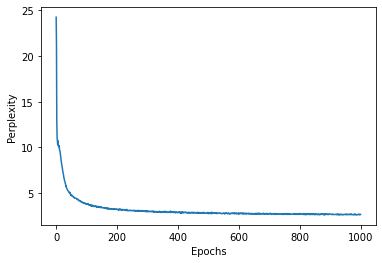

In [5]:
from matplotlib import pyplot as plt

plt.plot(all_perplexity)
plt.ylabel('Perplexity')
plt.xlabel('Epochs')
plt.show()

# Task 2

In [6]:
import random
import string

for i in range(5):
    random_string = ''.join(random.choices(string.ascii_lowercase, k=5))
    print(f'Input string: {random_string}')
    print('----------------------------')
    print('Generated text:')
    print(generate(decoder, prime_str=random_string))
    print('----------------------------')
    print()


Input string: cjdfj
----------------------------
Generated text:
cjdfjected he come on your are now,
But thou may on. O the common in the eye.
The defis o' the sung or tr
----------------------------

Input string: dvdqt
----------------------------
Generated text:
dvdqtower,
The treads chose most worse thine old our all viient and servates.

GLOUCESTER:
The king is fo
----------------------------

Input string: hjguk
----------------------------
Generated text:
hjguker, sooth,
Let her wert she converd your cloud. A meerent's rite
And much to beseech you that thy wo
----------------------------

Input string: dspbc
----------------------------
Generated text:
dspbcess, is he journer,
Like forbusting and to be pition,
Will the seyelly? I am wounder.

BUCKINGHAM:
M
----------------------------

Input string: pyhle
----------------------------
Generated text:
pyhless to him.

VOLUMNIA:
Now, now like the chamber-fear'd in this arm the
discovery of his hattle shall
-------------------------

# Task 3

In [7]:
input_strings = ['The', 'What is', 'Shall I give', ' X087hNYB BHN BYFVuhsdbs']
for i in input_strings:
    print(f'Input string: {i}')
    print('----------------------------')
    print('Generated text:')
    print(generate(decoder, prime_str=i))
    print('----------------------------')
    print()

Input string: The
----------------------------
Generated text:
The true a which with him in the restade all.
O words he can day of the father friend,
Which comfort, a
----------------------------

Input string: What is
----------------------------
Generated text:
What is past that voice, some sickly king?
The quarrels and Lancelos:
Salte affah, mick a wife, and to trie
----------------------------

Input string: Shall I give
----------------------------
Generated text:
Shall I gives, and be quickly mother of sight
Thou man our Romans of your comfort.

JULIET:
Come, he unto us unt
----------------------------

Input string:  X087hNYB BHN BYFVuhsdbs
----------------------------
Generated text:
 X087hNYB BHN BYFVuhsdbs:
You to know him for the soldier and dead,
So made fail to kneel, sir, good thought
The did sleep, 
----------------------------

